# Spike Challenge - Predicción de precios de insumos básicos en Chile

En este desafío vamos a ver si somos capaces de predecir el precio de un insumo básico,
como la leche, a partir de variables climatológicas y macroeconómicas. No siempre estos
datos nos entregan toda la información que nos gustaría, como por ejemplo señales claras
del avance de la sequía a lo largo del país, sin embargo, nos permite entender otro tipo de
efectos, como movimientos en ciertos sectores de la economía

Autor: Daniel Pereda

# 0. Cargar paquetes

Paquetes utilizados:

- pandas==1.1.5
- numpy==1.19.5
- matplotlib==3.3.4
- seaborn==0.11.1
- statsmodels==0.12.2
- missingno==0.4.2
- pystan==2.19.1.1
- prophet==1.0
- sklearn==0.24.2

*Nota*: No cargué todos los paquetes al comienzo para que sea más fácil leer el desarrollo y ver dónde utilicé cada uno.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from tqdm import tqdm
from matplotlib import rcParams
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# utilities viene de un paquete personal con funciones que utilizo en proyectos
# para este desafío tomé 2 funciones para visualizar distribuciones y correlaciones
from utilities import distplot, plot_corr_one_vs_all

%matplotlib inline

rcParams['figure.figsize'] = 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['lines.linewidth'] = 2.5

# 1. Datos: Precipitaciones, Indicadores Económicos Banco Central

- Cargar archivo precipitaciones.csv con las precipitaciones medias mensuales registradas entre enero 1979 y abril 2020. (Unidad: mm).

In [2]:
# Al inspeccionar vemos que date está en formato Año/Mes/Día y en la columna date
precipitaciones = pd.read_csv("precipitaciones.csv", parse_dates = ["date"])
precipitaciones.head(2)

date  Coquimbo  Valparaiso  Metropolitana_de_Santiago  \
0 1989-02-01  0.719033    0.117045                   0.028272   
1 1998-10-01  0.065216    0.000000                   0.011493   

   Libertador_Gral__Bernardo_O_Higgins     Maule    Biobio  La_Araucania  \
0                                  0.0  0.724667  9.172945     22.595834   
1                                  0.0  0.008968  2.089674     14.702087   

    Los_Rios  
0  52.268010  
1  45.142041

- Cargar archivo banco_central.csv con variables económicas.

A este no le haré parse_dates ya que hay fechas incorrectas (comentarios en gitter)

In [3]:
banco = pd.read_csv("banco_central.csv")
banco.head(2)

Periodo Imacec_empalmado Imacec_produccion_de_bienes  \
0  2013-03-01 00:00:00 UTC      102.796.218                  10.546.824   
1  2013-04-01 00:00:00 UTC      101.664.842                 999.272.757   

  Imacec_minero Imacec_industria Imacec_resto_de_bienes Imacec_comercio  \
0   978.554.365      102.297.537            114.994.919     110.729.395   
1   927.333.293      104.485.589            102.199.311     106.098.291   

  Imacec_servicios Imacec_a_costo_de_factores Imacec_no_minero  ...  \
0      100.064.328                103.163.651      103.405.852  ...   
1      102.600.107                101.937.319      102.766.884  ...   

  Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100  \
0                                        865.903.468      
1                                        867.806.065      

  Indice_de_produccion_industrial Indice_de_produccion_industrial__mineria  \
0                     102.761.705                               98.915.705   
1                     968.087.179                              914.276.663   

  Indice_de_produccion_industrial_electricidad__gas_y_agua  \
0                                                NaN         
1                                                NaN         

  Indice_de_produccion_industrial__manufacturera  \
0                                    108.387.837   
1                                    104.545.429   

  Generacion_de_energia_electrica_CDEC_GWh  \
0                              580.480.672   
1                              544.815.032   

  Indice_de_ventas_comercio_real_IVCM  \
0                                 NaN   
1                                 NaN   

  Indice_de_ventas_comercio_real_no_durables_IVCM  \
0                                             NaN   
1                                             NaN   

  Indice_de_ventas_comercio_real_durables_IVCM Ventas_autos_nuevos  
0                                          NaN             28577.0  
1                                          NaN             32206.0  

[2 rows x 85 columns]

# 2. Análisis de datos. Creación de variables


## 2.1 EDA

Realiza un análisis exploratorio de la base de datos, ¿Qué puedes decir de los datos,
sus distribuciones, valores faltantes, otros? ¿Hay algo que te llame la atención?

### 2.1.1 Precipitaciones

In [4]:
precipitaciones.info() # Parsing de los datos correctos, sin valores faltantes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496 entries, 0 to 495
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 496 non-null    datetime64[ns]
 1   Coquimbo                             496 non-null    float64       
 2   Valparaiso                           496 non-null    float64       
 3   Metropolitana_de_Santiago            496 non-null    float64       
 4   Libertador_Gral__Bernardo_O_Higgins  496 non-null    float64       
 5   Maule                                496 non-null    float64       
 6   Biobio                               496 non-null    float64       
 7   La_Araucania                         496 non-null    float64       
 8   Los_Rios                             496 non-null    float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 35.0 KB


Por la cantidad de datos ($496$), la granularidad debería ser mensual, con 12 datos por año excepto el 2020 con 4. Hagamos un sanity check

In [5]:
precipitaciones["Year"] = precipitaciones.date.dt.year
precipitaciones.groupby("Year").size()

Year
1979    12
1980    12
1981    12
1982    12
1983    12
1984    12
1985    12
1986    12
1987    12
1988    12
1989    12
1990    12
1991    12
1992    12
1993    12
1994    12
1995    12
1996    12
1997    12
1998    12
1999    12
2000    12
2001    12
2002    12
2003    12
2004    12
2005    12
2006    12
2007    12
2008    12
2009    12
2010    12
2011    12
2012    12
2013    12
2014    12
2015    12
2016    12
2017    12
2018    12
2019    12
2020     4
dtype: int64

Al ver las distribuciones notamos que los datos tienen sentido, las regiones de la zona norte y centro en donde llueve menos
presentan altos nivel de skewness, mientras que las que están más al Sur siguen teniendo cola pero con valores más cercanos a 1.

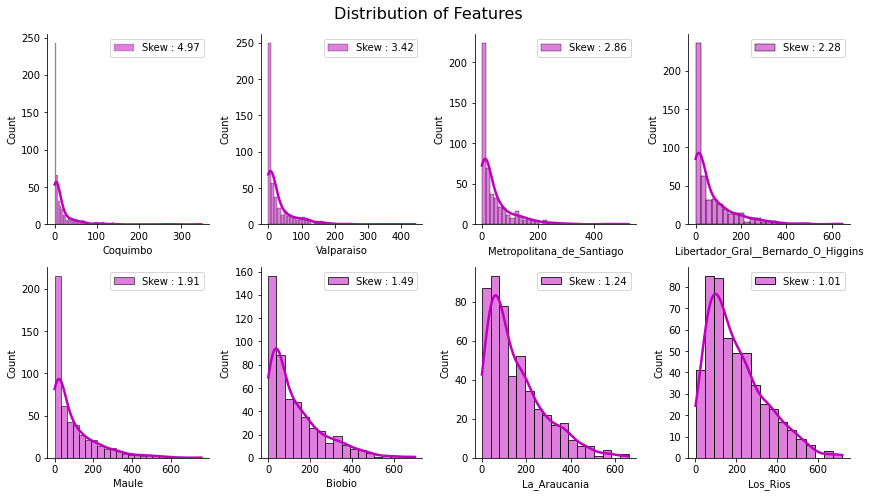

In [6]:
distplot(precipitaciones, precipitaciones.columns[1:-1], 2, 4, figsize = (12,7))

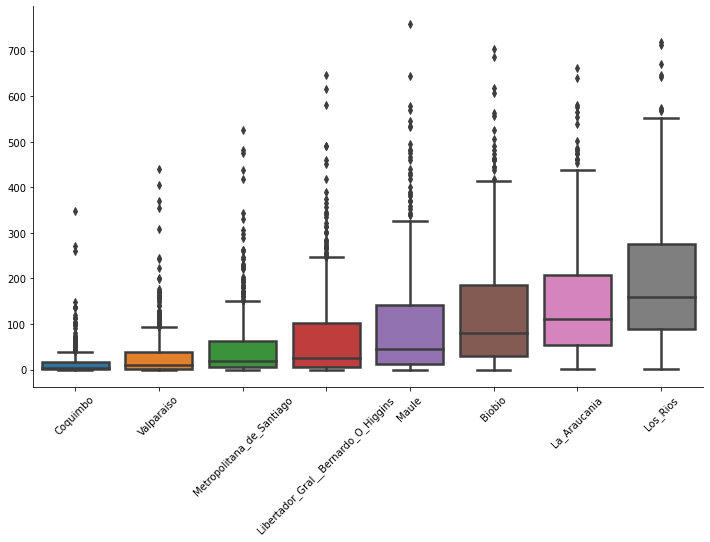

In [7]:
plt.figure(figsize = (12,7))
sns.boxplot(data=precipitaciones.iloc[:, 1:-1]) # df.boxplot() pero más bonito
plt.xticks(rotation=45); # No mostrar ticks

In [8]:
precipitaciones["Mes"] = precipitaciones.date.dt.month
precipitaciones.groupby("Mes").agg([np.mean, np.std]).T

Mes                                                1            2   \
Coquimbo                            mean     2.766008     2.944610   
                                    std      2.455758     2.760183   
Valparaiso                          mean     3.062071     3.222844   
                                    std      3.151399     4.033771   
Metropolitana_de_Santiago           mean     5.278003     6.262975   
                                    std      5.338101     6.953434   
Libertador_Gral__Bernardo_O_Higgins mean     3.961525     6.011637   
                                    std      6.164700     8.406996   
Maule                               mean     8.767497    14.286021   
                                    std      9.898084    19.106858   
Biobio                              mean    25.871496    31.972638   
                                    std     25.808050    39.384971   
La_Araucania                        mean    45.797142    46.460731   
                                    std     35.414021    44.466423   
Los_Rios                            mean    76.650672    71.807902   
                                    std     46.283944    56.013093   
Year                                mean  1999.500000  1999.500000   
                                    std     12.267844    12.267844   

Mes                                                3            4   \
Coquimbo                            mean     4.486968     9.659514   
                                    std      6.979262    17.164917   
Valparaiso                          mean     6.007330    20.004618   
                                    std      7.058992    31.917815   
Metropolitana_de_Santiago           mean     8.573767    37.341471   
                                    std      9.879403    50.544107   
Libertador_Gral__Bernardo_O_Higgins mean    11.427342    53.699936   
                                    std     13.515659    63.647642   
Maule                               mean    21.113824    74.231390   
                                    std     26.138406    71.334356   
Biobio                              mean    41.026035   104.794438   
                                    std     32.081657    76.816094   
La_Araucania                        mean    66.872759   130.978787   
                                    std     35.385320    77.032465   
Los_Rios                            mean   112.052937   185.423141   
                                    std     50.348127    86.076113   
Year                                mean  1999.500000  1999.500000   
                                    std     12.267844    12.267844   

Mes                                                5            6   \
Coquimbo                            mean    30.024081    42.953674   
                                    std     32.406879    50.115905   
Valparaiso                          mean    62.905020    92.798588   
                                    std     54.280615    87.154812   
Metropolitana_de_Santiago           mean    96.428897   132.383295   
                                    std     76.176689   119.792581   
Libertador_Gral__Bernardo_O_Higgins mean   152.075584   196.006548   
                                    std    114.387375   145.770132   
Maule                               mean   205.537972   259.730409   
                                    std    156.109439   151.239933   
Biobio                              mean   256.004208   305.336137   
                                    std    173.375693   133.263626   
La_Araucania                        mean   270.771790   327.173541   
                                    std    158.952817   124.437103   
Los_Rios                            mean   324.025799   379.998372   
                                    std    158.971602   129.527071   
Year                                mean  1999.000000  1999.000000   
                                    std     11.979149    11.979149   

Mes    

Finalmente ordenamos por fecha.

In [9]:
precipitaciones.sort_values(by = "date", inplace = True)

### 2.1.2 Banco Central

Veamos primero la cantidad y el rango de fechas de estos datos, para ver como se compara con el de precipitaciones

In [10]:
banco_shape = banco.shape
print(banco_shape)
banco.Periodo.agg([min,max])

(614, 85)


min    1970-01-01 00:00:00 UTC
max    2020-13-01 00:00:00 UTC
Name: Periodo, dtype: object

Inmediatamente vemos que hay una fecha incorrecta, debemos cambiar el mes "13" por el mes correcto.

In [11]:
banco[banco.Periodo >= "2020-01-01"]

Periodo Imacec_empalmado Imacec_produccion_de_bienes  \
84   2020-01-01 00:00:00 UTC      110.288.587                 110.053.602   
85   2020-02-01 00:00:00 UTC      106.982.117                 109.066.914   
86   2020-03-01 00:00:00 UTC      114.025.267                 114.239.103   
87   2020-04-01 00:00:00 UTC      988.542.998                 100.570.487   
88   2020-05-01 00:00:00 UTC      982.393.209                 969.940.132   
89   2020-13-01 00:00:00 UTC              NaN                         NaN   
90   2020-06-01 00:00:00 UTC      968.929.046                 909.523.847   
91   2020-07-01 00:00:00 UTC      966.693.225                 933.369.433   
92   2020-08-01 00:00:00 UTC      101.314.552                 926.876.935   
93   2020-09-01 00:00:00 UTC      103.201.091                 922.072.659   
94   2020-10-01 00:00:00 UTC      108.402.879                 103.551.978   
145  2020-11-01 00:00:00 UTC              NaN                         NaN   

    Imacec_minero Imacec_industria Imacec_resto_de_bienes Imacec_comercio  \
84    971.096.859      107.389.384            122.090.238     121.522.337   
85    970.172.781      101.005.355            124.713.152     119.993.696   
86    102.936.421      106.375.174            129.143.951     121.312.282   
87    986.442.174      969.425.393            104.850.643     926.889.279   
88    106.092.921      937.147.742            924.598.764     893.637.866   
89            NaN              NaN                    NaN     803.222.345   
90    103.616.298      920.403.499             80.182.653     891.539.668   
91    104.988.256      969.434.205            813.420.488     931.746.336   
92    103.697.799      980.026.279            798.286.232     108.232.893   
93    100.589.658      100.132.069            793.042.271     111.622.999   
94    103.153.982      108.477.999            998.283.785     116.649.655   
145           NaN              NaN                    NaN             NaN   

    Imacec_servicios Imacec_a_costo_de_factores Imacec_no_minero  ...  \
84       108.043.984                110.123.027      111.698.153  ...   
85       102.962.024                106.934.379      108.021.397  ...   
86       113.370.357                114.477.486      115.187.423  ...   
87       100.658.794                 99.848.482      987.676.061  ...   
88       101.805.244                987.747.993      972.149.892  ...   
89               NaN                        NaN              NaN  ...   
90       103.608.903                974.199.885       96.001.603  ...   
91       996.428.565                966.321.757      955.926.074  ...   
92       104.806.496                100.569.037       10.092.332  ...   
93       108.317.886                102.561.718      103.388.943  ...   
94       109.798.567                108.112.878      108.891.792  ...   
145              NaN                        NaN              NaN  ...   

    Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100  \
84                                         103.527.477      
85                                         104.899.349      
86                                         107.247.137      
87                                         105.982.122      
88                                         101.774.069      
89                                                 NaN      
90                                         100.561.281      
91                                         100.164.187      
92                                          10.151.671      
93                                         100.765.123      
94                                         102.554.585      
145                                                NaN      

    Indice_de_produccion_industrial Indice_de_produccion_industrial__mineria  \
84                      101.007.846                              926.196.774   
85                      973.346.365                              914.239.245   
86                      105.057.9

Vemos que el único mes faltante es Diciembre, además hubo un problema con la recolección de datos en Noviembre la cual persiste en Diciembre.

In [12]:
banco.loc[banco.Periodo == "2020-13-01 00:00:00 UTC", "Periodo"] = "2020-12-01 00:00:00 UTC"

Cambiamos ahora la columna "Periodo" a datetime y deslocalizamos para tener consistencia con los datos de precipitación. En caso de existir otra fecha incorrecta, esto nos arrogará un error.

In [13]:
banco["Periodo"] = pd.to_datetime(banco["Periodo"]).dt.date.astype('datetime64')
banco.sort_values(by = "Periodo", inplace = True) # Ordenar por fecha

Tenemos datos desde Enero 1970 hasta Diciembre 2020, esto corresponde a $(2020 - 1970 + 1) \times 12 = 612$ datos, pero tenemos 614 filas. Esto significa que tenemos filas duplicadas que tendremos que arreglar.

In [14]:
banco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 146 to 89
Data columns (total 85 columns):
 #   Column                                                                              Non-Null Count  Dtype         
---  ------                                                                              --------------  -----         
 0   Periodo                                                                             614 non-null    datetime64[ns]
 1   Imacec_empalmado                                                                    300 non-null    object        
 2   Imacec_produccion_de_bienes                                                         300 non-null    object        
 3   Imacec_minero                                                                       300 non-null    object        
 4   Imacec_industria                                                                    301 non-null    object        
 5   Imacec_resto_de_bienes                           

Notamos que la cantidad de valores nulos en algunas columnas es significativamente alta. Esta es una de las razones por las cuales columnas que deberían ser numéricas son reconocidas como ```object```.

Utilizando el paquete ```missingno``` podemos visualizar los valores nulos y ver si hay algún patrón

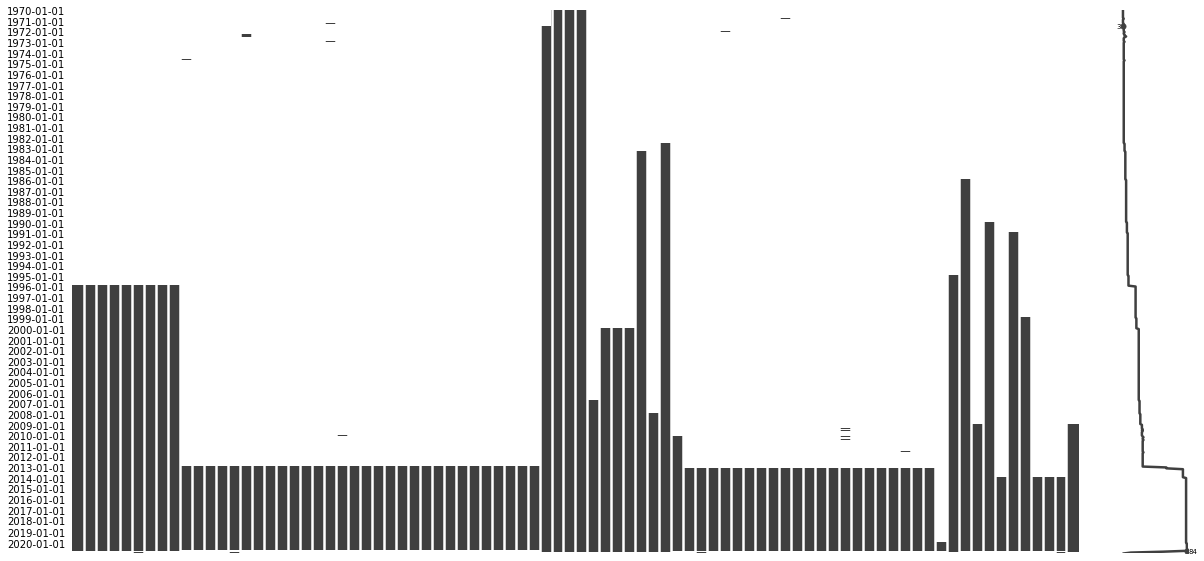

In [15]:
import missingno as msno
msno.matrix(banco.set_index("Periodo"), freq='YS', figsize = (20, 10), fontsize=8);

Efectivamente, la mayoría de los datos se tienen solo desde el año 2013. Tenemos que analizar qué haremos con esto, dependiendo del rango de fechas de nuestro target set ```precio_leche.csv```, correlación entre columnas y resultados del modelo base.

Por último, me llama la atención que la mayoría de los números tienen doble punto $933.369.433$ por lo que tendremos que hacer una limpieza para transformarlos realmente en números.

Por todo lo anterior, no podemos sacar mucha información estadística de los números de este dataset antes de limpiarlo.

In [16]:
banco.describe().T

count          mean  \
Precio_de_la_onza_troy_de_oro_dolaresoz             613.0    578.706574   
Precio_de_la_onza_troy_de_plata_dolaresoz           613.0     54.202123   
Precio_del_diesel_centavos_de_dolargalon            172.0    215.337558   
Precio_del_gas_natural_dolaresmillon_de_unidade...  253.0      5.055426   
Precio_del_petroleo_Brent_dolaresbarril             253.0     63.673202   
Precio_del_petroleo_WTI_dolaresbarril               453.0     43.066137   
Precio_del_propano_centavos_de_dolargalon_DTN       157.0     88.528822   
Ventas_autos_nuevos                                 145.0  26694.082759   

                                                            std        min  \
Precio_de_la_onza_troy_de_oro_dolaresoz              468.018646    34.9400   
Precio_de_la_onza_troy_de_plata_dolaresoz             89.493857     1.3200   
Precio_del_diesel_centavos_de_dolargalon              68.625224    79.4900   
Precio_del_gas_natural_dolaresmillon_de_unidade...     8.580500     1.6128   
Precio_del_petroleo_Brent_dolaresbarril               29.704824    18.6000   
Precio_del_petroleo_WTI_dolaresbarril                 28.014437    11.3000   
Precio_del_propano_centavos_de_dolargalon_DTN         36.772454    29.2330   
Ventas_autos_nuevos                                 7170.231956  4658.0000   

                                                           25%         50%  \
Precio_de_la_onza_troy_de_oro_dolaresoz               292.5400    385.0400   
Precio_de_la_onza_troy_de_plata_dolaresoz               4.7600      6.0800   
Precio_del_diesel_centavos_de_dolargalon              162.4475    200.3400   
Precio_del_gas_natural_dolaresmillon_de_unidade...      2.8638      3.8851   
Precio_del_petroleo_Brent_dolaresbarril                39.9300     59.3700   
Precio_del_petroleo_WTI_dolaresbarril                  20.1000     30.3900   
Precio_del_propano_centavos_de_dolargalon_DTN          54.8880     88.0430   
Ventas_autos_nuevos                                 23701.0000  27912.0000   

                                                           75%        max  
Precio_de_la_onza_troy_de_oro_dolaresoz               828.8000   1969.780  
Precio_de_la_onza_troy_de_plata_dolaresoz              35.0800    431.028  
Precio_del_diesel_centavos_de_dolargalon              286.3925    384.380  
Precio_del_gas_natural_dolaresmillon_de_unidade...      5.9300    136.338  
Precio_del_petroleo_Brent_dolaresbarril                79.2700    133.900  
Precio_del_petroleo_WTI_dolaresbarril                  59.8000    133.930  
Precio_del_propano_centavos_de_dolargalon_DTN         110.7380    187.875  
Ventas_autos_nuevos                                 31800.0000  39263.000

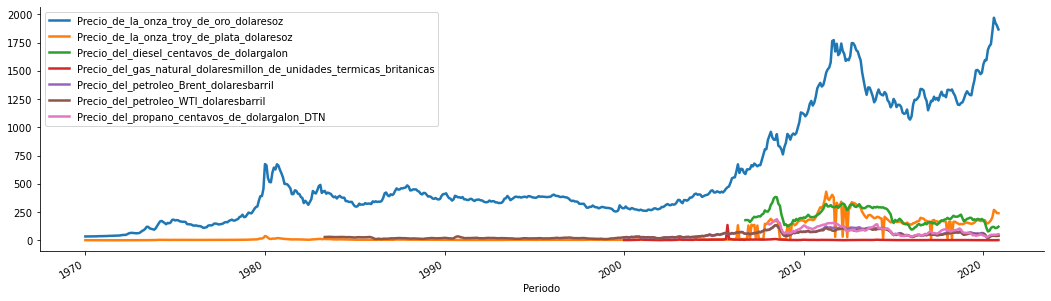

In [17]:
banco.set_index("Periodo").drop(columns = "Ventas_autos_nuevos").plot();

Podemos ver que existen datos para "Precio de la onza troy de oro dolaresoz" desde el año 1970 y que tal serie presenta una tendencia.
Por otro lado, las demás variables asociadas a Precios parecieran tener baja variación antes del año 2005.

Veamos sus distribuciones haciendo un slicing en tal año.

In [18]:
banco.set_index("Periodo").loc[:"2005-01-01"].describe().T 

count        mean  \
Precio_de_la_onza_troy_de_oro_dolaresoz             421.0  304.687482   
Precio_de_la_onza_troy_de_plata_dolaresoz           421.0    5.874636   
Precio_del_diesel_centavos_de_dolargalon              0.0         NaN   
Precio_del_gas_natural_dolaresmillon_de_unidade...   61.0    5.149541   
Precio_del_petroleo_Brent_dolaresbarril              61.0   29.227213   
Precio_del_petroleo_WTI_dolaresbarril               261.0   23.156015   
Precio_del_propano_centavos_de_dolargalon_DTN         0.0         NaN   
Ventas_autos_nuevos                                   0.0         NaN   

                                                           std    min     25%  \
Precio_de_la_onza_troy_de_oro_dolaresoz             132.912910  34.94  207.83   
Precio_de_la_onza_troy_de_plata_dolaresoz             3.760904   1.32    4.39   
Precio_del_diesel_centavos_de_dolargalon                   NaN    NaN     NaN   
Precio_del_gas_natural_dolaresmillon_de_unidade...    1.908447   2.44    3.50   
Precio_del_petroleo_Brent_dolaresbarril               6.393177  18.60   25.53   
Precio_del_petroleo_WTI_dolaresbarril                 7.144759  11.30   18.20   
Precio_del_propano_centavos_de_dolargalon_DTN              NaN    NaN     NaN   
Ventas_autos_nuevos                                        NaN    NaN     NaN   

                                                       50%     75%     max  
Precio_de_la_onza_troy_de_oro_dolaresoz             340.44  387.70  675.31  
Precio_de_la_onza_troy_de_plata_dolaresoz             5.12    6.26   38.26  
Precio_del_diesel_centavos_de_dolargalon               NaN     NaN     NaN  
Precio_del_gas_natural_dolaresmillon_de_unidade...    5.35    6.17   10.71  
Precio_del_petroleo_Brent_dolaresbarril              27.77   31.18   49.77  
Precio_del_petroleo_WTI_dolaresbarril                21.00   28.30   53.30  
Precio_del_propano_centavos_de_dolargalon_DTN          NaN     NaN     NaN  
Ventas_autos_nuevos                                    NaN     NaN     NaN

In [19]:
banco.set_index("Periodo").loc["2005-01-01":].describe().T

count          mean  \
Precio_de_la_onza_troy_de_oro_dolaresoz             193.0   1175.637202   
Precio_de_la_onza_troy_de_plata_dolaresoz           193.0    159.374619   
Precio_del_diesel_centavos_de_dolargalon            172.0    215.337558   
Precio_del_gas_natural_dolaresmillon_de_unidade...  193.0      5.031362   
Precio_del_petroleo_Brent_dolaresbarril             193.0     74.459793   
Precio_del_petroleo_WTI_dolaresbarril               193.0     70.010674   
Precio_del_propano_centavos_de_dolargalon_DTN       157.0     88.528822   
Ventas_autos_nuevos                                 145.0  26694.082759   

                                                            std        min  \
Precio_de_la_onza_troy_de_oro_dolaresoz              369.932504   422.5000   
Precio_de_la_onza_troy_de_plata_dolaresoz             96.280742     6.6221   
Precio_del_diesel_centavos_de_dolargalon              68.625224    79.4900   
Precio_del_gas_natural_dolaresmillon_de_unidade...     9.772281     1.6128   
Precio_del_petroleo_Brent_dolaresbarril               25.561291    23.3400   
Precio_del_petroleo_WTI_dolaresbarril                 22.579940    16.5200   
Precio_del_propano_centavos_de_dolargalon_DTN         36.772454    29.2330   
Ventas_autos_nuevos                                 7170.231956  4658.0000   

                                                           25%         50%  \
Precio_de_la_onza_troy_de_oro_dolaresoz               926.9600   1237.8000   
Precio_de_la_onza_troy_de_plata_dolaresoz             137.4330    165.0940   
Precio_del_diesel_centavos_de_dolargalon              162.4475    200.3400   
Precio_del_gas_natural_dolaresmillon_de_unidade...      2.8073      3.6196   
Precio_del_petroleo_Brent_dolaresbarril                55.1600     68.6200   
Precio_del_petroleo_WTI_dolaresbarril                  52.0100     65.4800   
Precio_del_propano_centavos_de_dolargalon_DTN          54.8880     88.0430   
Ventas_autos_nuevos                                 23701.0000  27912.0000   

                                                           75%        max  
Precio_de_la_onza_troy_de_oro_dolaresoz              1361.8000   1969.780  
Precio_de_la_onza_troy_de_plata_dolaresoz             196.5070    431.028  
Precio_del_diesel_centavos_de_dolargalon              286.3925    384.380  
Precio_del_gas_natural_dolaresmillon_de_unidade...      5.8242    136.338  
Precio_del_petroleo_Brent_dolaresbarril                99.0600    133.900  
Precio_del_petroleo_WTI_dolaresbarril                  89.4100    133.930  
Precio_del_propano_centavos_de_dolargalon_DTN         110.7380    187.875  
Ventas_autos_nuevos                                 31800.0000  39263.000

Vemos que antes del 2005 la distribución es bastante distinta a después del 2005. En caso de que usemos alguna de estas variables en nuestro modelo, tendremos que tener esto en cuenta para elegir el período de tiempo que utilizaremos de entrenamiento.

## 2.2 Limpieza de datos

Como vimos anteriormente, los datos de precipitaciones están bien. De manera que en esta sección nos enfocaremos en limpiar los datos del banco central.

### 2.2.1 Duplicados

In [20]:
banco[banco.duplicated(keep=False)]

Periodo Imacec_empalmado Imacec_produccion_de_bienes Imacec_minero  \
65 2018-08-01      109.690.834                 994.693.267   101.027.633   
66 2018-08-01      109.690.834                 994.693.267   101.027.633   
78 2019-08-01      113.886.371                 103.237.519   106.828.407   
79 2019-08-01      113.886.371                 103.237.519   106.828.407   

   Imacec_industria Imacec_resto_de_bienes Imacec_comercio Imacec_servicios  \
65        1.051.861            931.900.957     106.248.833      117.404.143   
66        1.051.861            931.900.957     106.248.833      117.404.143   
78      105.153.122            984.395.274     106.901.816      122.596.004   
79      105.153.122            984.395.274     106.901.816      122.596.004   

   Imacec_a_costo_de_factores Imacec_no_minero  ...  \
65                109.458.386      110.578.221  ...   
66                109.458.386      110.578.221  ...   
78                113.695.907      114.580.893  ...   
79                113.695.907      114.580.893  ...   

   Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100  \
65                                        911.086.301      
66                                        911.086.301      
78                                        948.715.254      
79                                        948.715.254      

   Indice_de_produccion_industrial Indice_de_produccion_industrial__mineria  \
65                     102.691.109                              983.228.221   
66                     102.691.109                              983.228.221   
78                     104.034.103                              102.619.922   
79                     104.034.103                              102.619.922   

   Indice_de_produccion_industrial_electricidad__gas_y_agua  \
65                                        108.792.744         
66                                        108.792.744         
78                                        107.666.732         
79                                        107.666.732         

   Indice_de_produccion_industrial__manufacturera  \
65                                    105.596.535   
66                                    105.596.535   
78                                    104.591.452   
79                                    104.591.452   

   Generacion_de_energia_electrica_CDEC_GWh  \
65                              654.060.172   
66                              654.060.172   
78                                     6598   
79                                     6598   

   Indice_de_ventas_comercio_real_IVCM  \
65                         113.525.936   
66                         113.525.936   
78                         116.203.109   
79                         116.203.109   

   Indice_de_ventas_comercio_real_no_durables_IVCM  \
65                                     103.995.337   
66                                     103.995.337   
78                                     107.385.297   
79                                     107.385.297   

   Indice_de_ventas_comercio_real_durables_IVCM Ventas_autos_nuevos  
65                                   15.375.472             38729.0  
66                                   15.375.472             38729.0  
78                                   15.342.321             33059.0  
79                                   15.342.321             33059.0  

[4 rows x 85 columns]

Eliminamos las 2 filas duplicadas.

In [21]:
banco.drop_duplicates(inplace = True)
assert banco.shape == (banco_shape[0] - 2, banco_shape[1])

Por ahora eliminamos las filas que tienen valores idénticos en todas las columnas, la cantidad de datos totales calza con las que deben ser (612), sin
embargo veamos si hay fechas repetidas.

In [22]:
banco.Periodo.duplicated().sum()

0

Excelente, no hay fechas repetidas. Podemos dejar la fecha como índice.

In [23]:
banco.set_index("Periodo", inplace = True)

### 2.2.2 Arreglar números

De las primeras dos filas de datos que miramos anteriormente, notamos que habían valores nulos, por lo que si bien todos los indicadores (Imacec, PIB, impuestos, etc) deberían ser numéricos, serán reconocidos como ```object```. Además vemos que los números aparecen con doble punto, si revisamos la página del banco central, vemos que el [Imacec](https://si3.bcentral.cl/siete/ES/Siete/Canasta?idCanasta=DPKEG1166011) tiene valores en torno a los cientos, analogamente para los [índices de ventas](https://www.ine.cl/estadisticas/economia/comercio-servicios-y-turismo/ventas-de-comercio-al-por-menor). Ahora, si cambiamos todos los índices por ejemplo de Imacec de forma consistente, no debería haber diferencia si el valor es 109.690834 o 109690.834 (dependiendo del modelo, podríamos necesitar hacer un cambio de escala o estandarizar los datos, y en caso de no hacerlo sí hay diferencia entre 109 y 109*100).

Las siguientes 2 funciones serán útiles para limpiar los datos y para separar las columnas según estimemos conveniente

In [24]:
import re

def delete_non_numeric(string):
    s = re.sub("[^0-9]", "", str(string))
    if s == "": return np.nan
    else: return float(s) 

def col_contains(df, string):
    return [col for col in df.columns if (string in col)]

Podemos separar las columnas de los datos bancarios en:

- Imacec
- PIB
- INE
- Indices
- Precios
- Otros

Si bien, vamos a repetir mucho código. Esto servirá más adelante para estudiar correlaciones entre variables y target, además de ver como se comportan datos del mismo grupo.

#### Imacec

In [25]:
# Imacec no ha tenido valores bajo 20 ni sobre 200 durante los años 1996 a 2021
def fix_scale_imacec(number):
    if number < 2: return 100*number
    elif  15 > number > 4: return 10*number
    elif number > 200: return number/10
    else: return number

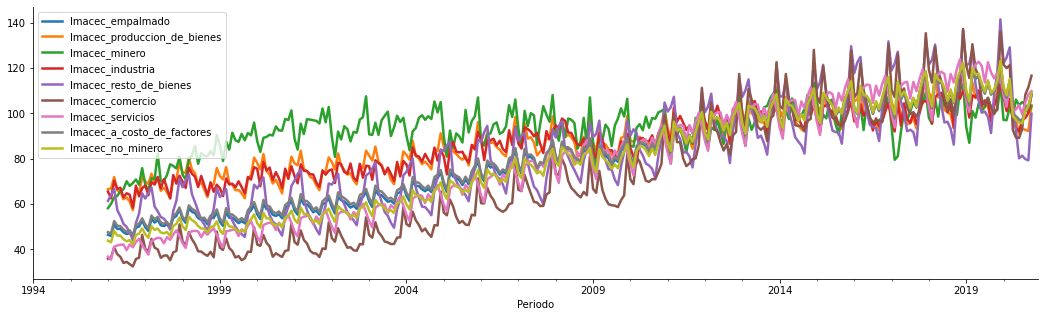

In [26]:
imacec_cols = col_contains(banco, "Imacec")
for col in imacec_cols:
    banco[col] = banco[col].apply(delete_non_numeric)/(1e6)
    banco[col] = banco[col].apply(fix_scale_imacec)

banco.loc["1994-01-01":][imacec_cols].plot();

#### PIB

Vemos que los valores no están correctos y parecieran seguir un patrón. A priori no se me ocurre una forma inteligente de arreglar todas las columnas, y aún no sabemos si el tiempo invertido en esto será necesario, por lo que las arreglaré de forma aproximada y más adelante podemos cambiar los números en los quantiles extremos por NaN y reemplazarlos o por interpolación o tomando medias móviles.

In [27]:
def fix_scale_pib(number):
    if number < 10: return 100*number
    elif  80 > number > 10: return 10*number
    elif number > 1000: return number/10
    else: return number

In [28]:
pib_cols = col_contains(banco, "PIB")
for col in pib_cols:
    banco[col] = banco[col].apply(delete_non_numeric)/(1e6)
    banco[col] = banco[col].apply(fix_scale_pib)

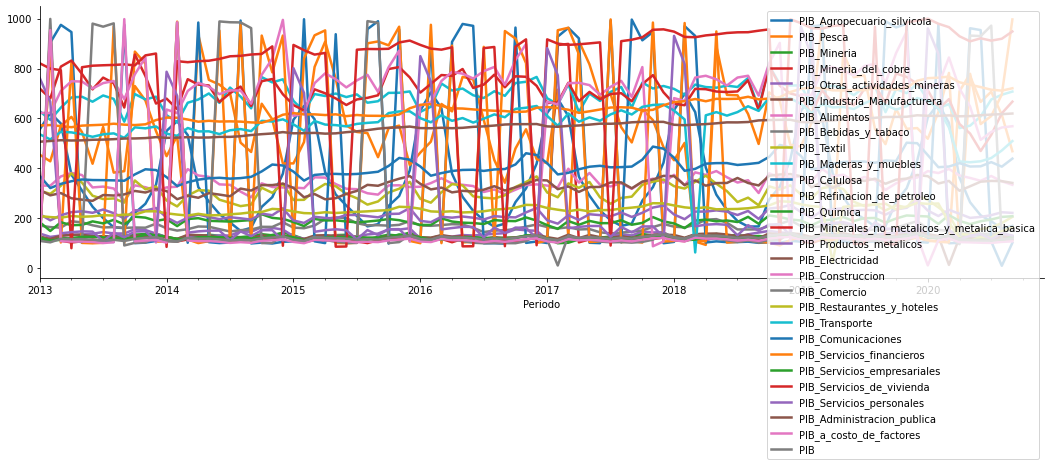

In [29]:
banco.loc["2013-01-01":][pib_cols].plot();

#### INE

Usaremos la misma funciones que para el PIB

In [30]:
ine_cols = col_contains(banco, "INE")
for col in ine_cols:
    banco[col] = banco[col].apply(delete_non_numeric)/(1e6)
    banco[col] = banco[col].apply(fix_scale_pib)

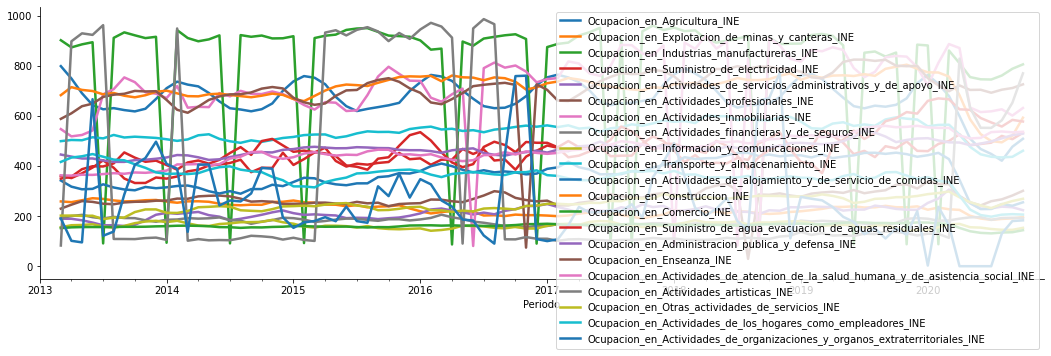

In [31]:
banco.loc["2013-01-01":][ine_cols].plot();

#### Indices

In [32]:
def fix_scale_indices(number):
    if number < 1: return 1000*number
    elif number < 10: return 100*number
    elif  100 > number > 10: return 10*number
    elif number > 1000: return number/10
    else: return number

In [33]:
indice_cols = col_contains(banco, "Indice")
for col in indice_cols:
    banco[col] = banco[col].apply(delete_non_numeric)/(1e6)
    banco[col] = banco[col].apply(fix_scale_indices)

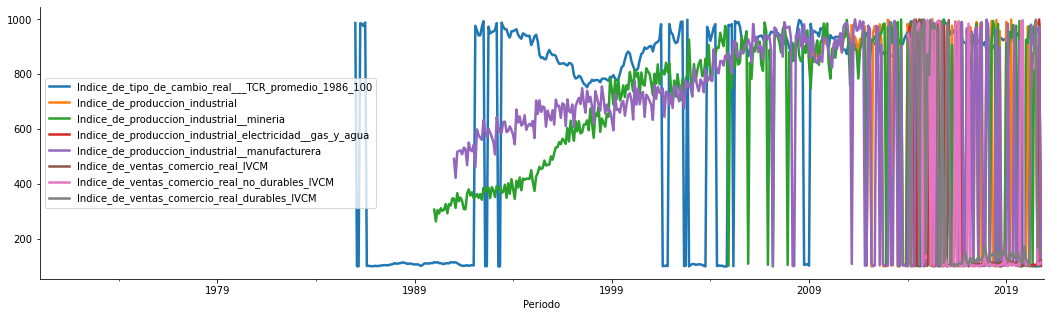

In [34]:
banco[indice_cols].plot();

#### Precios

In [35]:
precios_cols = col_contains(banco, "Precio_")
for col in precios_cols:
    banco[col] = banco[col].apply(delete_non_numeric)/(1e6)

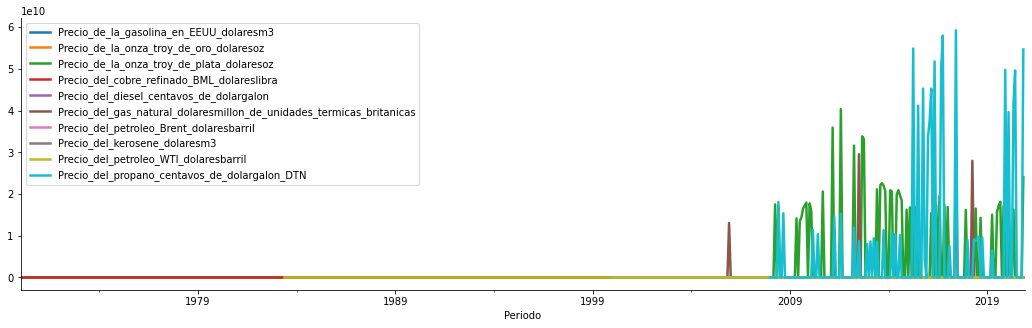

In [36]:
banco[precios_cols].plot();

#### Otros

In [37]:
otros_cols = set(banco.columns).difference(set(imacec_cols + pib_cols + ine_cols + indice_cols + precios_cols))
print(otros_cols)
for col in otros_cols:
    banco[col] = banco[col].apply(delete_non_numeric)

{'Ocupados', 'Tipo_de_cambio_del_dolar_observado_diario', 'Impuesto_al_valor_agregado', 'Ventas_autos_nuevos', 'Tipo_de_cambio_nominal_multilateral___TCM', 'Derechos_de_Importacion', 'Generacion_de_energia_electrica_CDEC_GWh', 'No_sabe__No_responde_Miles_de_personas'}


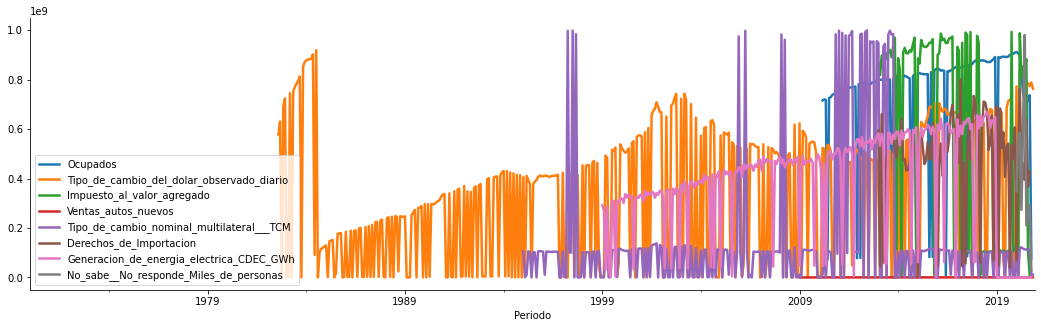

In [38]:
banco[otros_cols].plot();

### Outliers

Finalmente cambiamos los valores que no logré limpiar bien por NaN. Además tomaré los datos solo desde el 2005, por lo comentado anteriormente.

Si el modelo no logra los resultados esperados, tendremos entonces que limpiar mejor los datos.

In [39]:
lb, ub = banco.quantile(0.01), banco.quantile(0.99) 
banco_new = banco.loc["2005-01-01":][(banco <  ub) & (banco > lb)]

Esto logra mejorar bastante algunas de las columnas, como las que listamos en "otros"

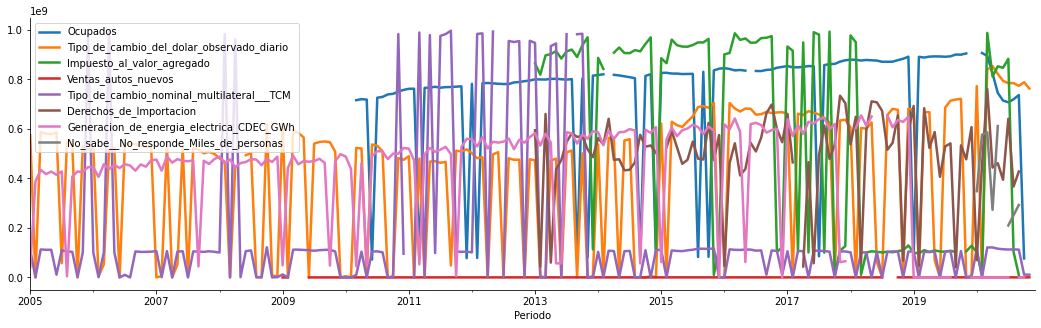

In [40]:
banco_new[otros_cols].plot();

# 3. Visualización

## 3.1 Crear función que permita graficar series históricas de precipitaciones

In [41]:
def plot_precipitaciones(nombre_region:str, fecha_inicio:str, fecha_termino:str):
    
    regiones = precipitaciones.columns[1:-2] # no tomar las columnas date, Mes y Year.
    fechas = precipitaciones.date.astype(str).unique()
    
    if fecha_inicio > fecha_termino:
        print("Fecha de inicio debe ser menor a fecha de termino")
    
    elif nombre_region not in regiones:
        print(f"Región debe ser una de la siguientes: {regiones}")
    
    elif fecha_inicio not in fechas or fecha_termino not in fechas:
        print(f"Fecha inválida, ingrese fecha en el rango 1979-01-01 - 2020-04-01 con dia = 01")
    
    else:
        precipitaciones[(precipitaciones.date >  fecha_inicio) & (precipitaciones.date < fecha_termino)].plot(x = "date", 
                                                                                                          y = nombre_region,
                                                                                                          figsize = (20, 7),
                                                                                                          title = "Precipitaciones (mm)")
        plt.show()

## 3.2 Graficar utilizando 3.1

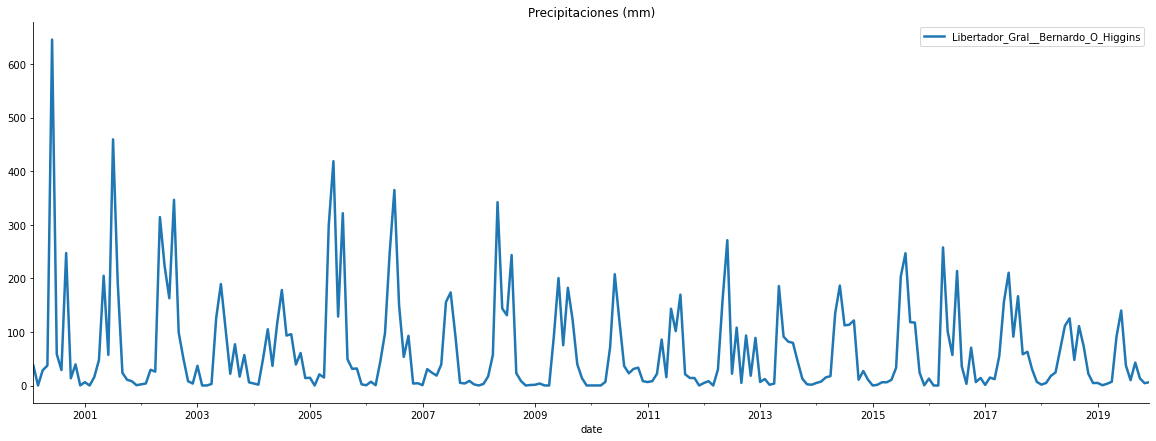

In [42]:
plot_precipitaciones("Libertador_Gral__Bernardo_O_Higgins", "2000-01-01", "2020-01-01")

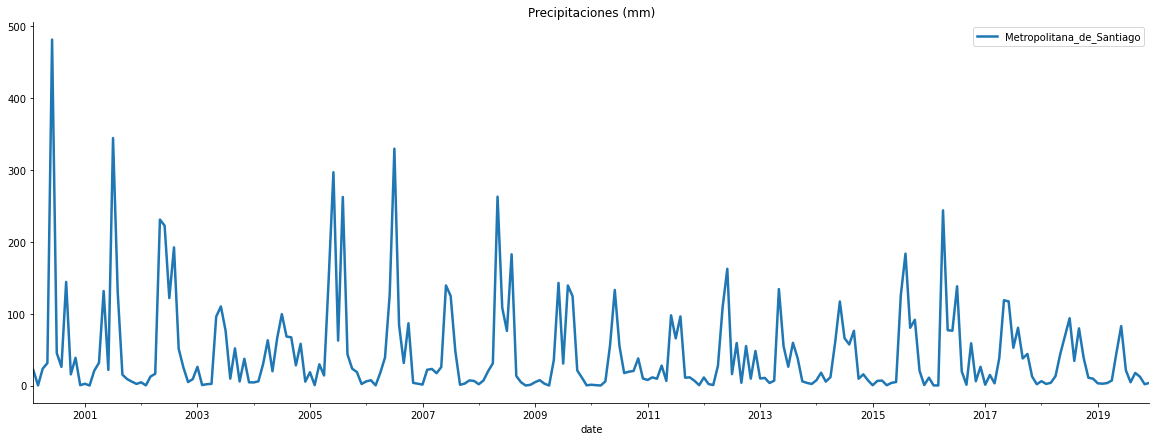

In [43]:
plot_precipitaciones("Metropolitana_de_Santiago", "2000-01-01", "2020-01-01")

- ¿ Qué observas con respecto a estacionalidades y tendencias?

**Respuesta:** Existe estacionalidad, podemos ver que las precipitaciones son bajas durante el verano, crecen hasta tener máximos en invierno y luego decrecen en primavera. Por otro lado, no se puede ver una tendencia muy marcada, solo en la escala y máximos anuales que se han vuelvos más pequeños y menos habituales que al comienzo de los años 2000.

## 3.3 Funcion que grafica múltiples series de tiempo

In [44]:
def plot_precipitaciones_mensuales(lista_años, nombre_region):
    regiones = precipitaciones.columns[1:].to_list()
    if nombre_region not in regiones:
        print(f"Región debe ser una de la siguientes: {regiones}")
    
    lista_años = [int(año) for año in lista_años] # En caso de que alguien entregue "2020" o 2020.0
    df =  precipitaciones[precipitaciones.Year.isin(lista_años)][["Year", "Mes", "date", nombre_region]]
    
    # Si la lista de años no coincide con valores de nuestro dataset, entonces reportarlo
    if len(df) < 1:
        print("No hay datos para la lista de años proporcionada")
    else:
        df.set_index("Mes", inplace = True)
        
        años = df.Year.unique()
        missing_años = [año for año in lista_años if año not in años]
        if missing_años: print("No hay datos para los años", missing_años)
            
        nombre_region_title = " ".join(nombre_region.split("_"))
        df.groupby("Year")[nombre_region].plot(title = f"Precipitaciones en mm: {nombre_region_title}", legend = True)

## 3.4 Región del Maule para distintos años

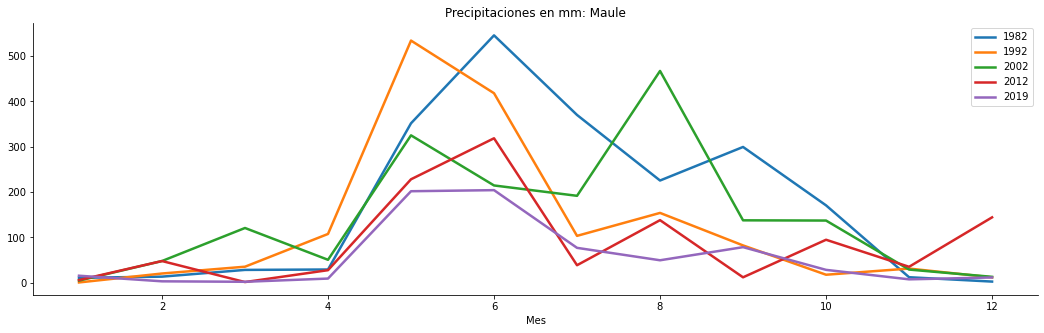

In [45]:
plot_precipitaciones_mensuales([1982, 1992, 2002, 2012, 2019], 'Maule')

- ¿Qué puedes concluir de estos gráficos?

**Respuesta:** Podemos concluir que la cantidad de precipitaciones ha disminuído considerablemente durante los últimos 40 años, en 2019 es pŕacticamente la mitad de
las precipitaciones en 1982. Por otro lado, podemos ver cómo los máximos ocurren generalmente en el mes de Junio y Agosto.

## 3.5 Funcion que grafica dos series históricas del PIB

In [46]:
def plot_pib(serie1:str, serie2:str, fecha_inicio:str, fecha_termino:str):
    pib_cols = col_contains(banco, "PIB")
    
    if fecha_inicio > fecha_termino:
        print("Fecha de inicio debe ser menor a fecha de termino")
    
    elif (serie1 not in pib_cols) or (serie2 not in pib_cols):
        print(f"Serie debe ser una de la siguientes: {pib_cols}")
        
    else:
        banco[fecha_inicio:fecha_termino][[serie1, serie2]].plot()

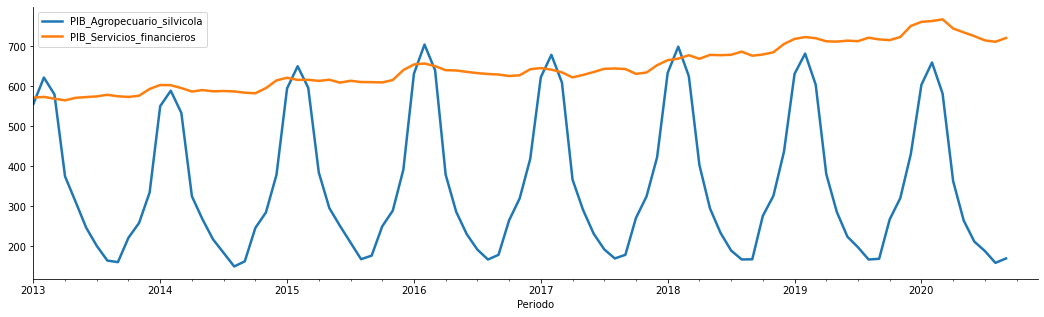

In [47]:
plot_pib('PIB_Agropecuario_silvicola', 'PIB_Servicios_financieros', "2013-01-01", "2021-01-01")

- ¿Qué puedes decir de cada serie en particular?

**Respuesta:** Podemos ver que el PIB Agropecuario y silvicola presenta una estacionalidad marcada, con máximos en verano y mínimos en invierno y sin una tendencia clara. Por otro lado, el PIB de Servicios financieros ha ido aumentando mostrando una tendencia al alza.

- ¿Hay alguna relación entre estas dos series?

**Respuesta:** A partir de este gráfico, no se ve una relación clara entre ambas series.

# 4. Tratamiento y creación de variables

- ¿Cómo podríamos evaluar la correlación entre las distintas series de tiempo y cómo se tienen que correlacionar para entrenar un modelo? ¿Mucha correlación, no correlacionadas, da igual?

**Respuesta:** 

Calcular la correlación entre dos series de tiempo es un tema delicado, podemos ver en nuestras series de tiempo que existe una tendencia (los precios tienen a subir), esto hará que obtengamos correlaciones altas incluso cuando ambas series no tienen una relación real, esto se conoce como *relación espuria* ([página dedicada a mostrar este tipo de relaciones](http://www.tylervigen.com/spurious-correlations?fbclid=IwAR2so0gfVrlwBt8yAKBD_1ITQGDAwiY2q0j3CzOWpCG0X6d-NsFQAX2L8eI)). Por esta razón, veremos la correlación en las diferencias de primer orden, esto remueve la tendencia y nos permite mirar el efecto real.

Para entrenar un modelo, queremos tener variables que estén altamentes correlacionadas con nuestra variable objetivo (teniendo las precauciones mencionadas anteriormente para series de tiempo). Por otro lado, en general no es bueno que las características (features) estén altamente correlacionadas entre ellas, puesto que no estarían aportando información nueva y estarían sesgando el modelo (especialmente a modelos lineales).

Por último, en series de tiempo tenemos dos conceptos interesantes que tienen que ver con autocorrelación y autocorrelación parcial, la primera es la correlación entre $y_{t_1}$ y $y_{t_2}$ con $t_1 < t_2$. La segunda, elimina los efectos de otros períodos y nos permite estudiar el impacto puro de la variable en tiempo $t_1$ para predecir la variable en tiempo $t_2$. Al igual que para la correlación, tenemos que mirar esto en la serie de tiempo estacionaria. Las variables que generamos a partir de esto se conocen como lags y general mejoran el rendimiento de los modelos.

## 4.1 Datos Banco Central

Primero vemos que las columnas relacionadas a Precios no están correlacionadas entre sí o con el Imacec. Mientras que las columnas del imacec están altamente correlacionadas en su grupo.

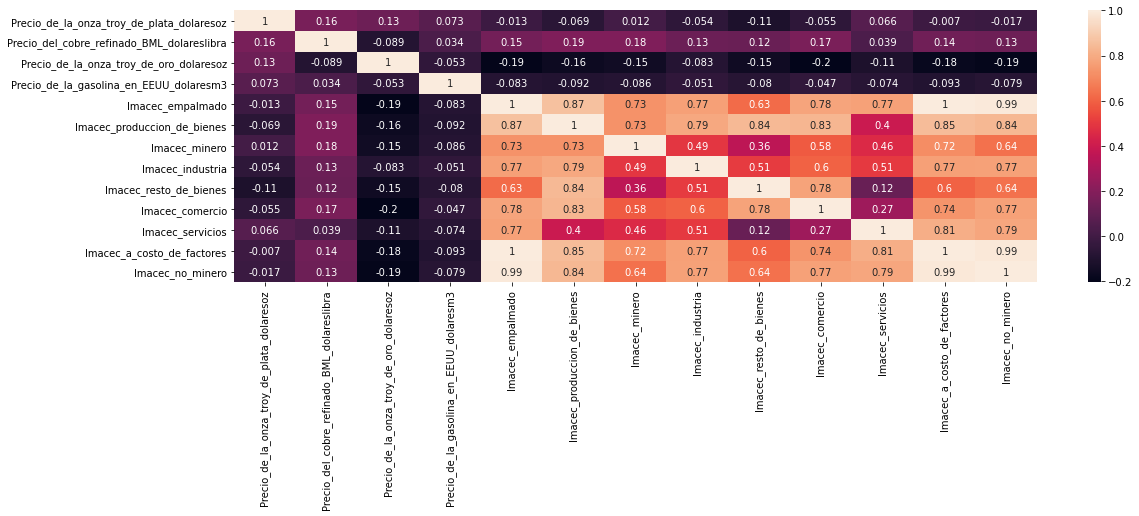

In [48]:
precios_cols = ["Precio_de_la_onza_troy_de_plata_dolaresoz", "Precio_del_cobre_refinado_BML_dolareslibra", 
                "Precio_de_la_onza_troy_de_oro_dolaresoz", "Precio_de_la_gasolina_en_EEUU_dolaresm3"]
banco_cols =  precios_cols + imacec_cols
sns.heatmap(banco[banco_cols].diff().dropna().corr(), annot=True);

Si vieramos las correlaciones en las series no estacionarias, la mayoría de las columnas tienen alta correlación.

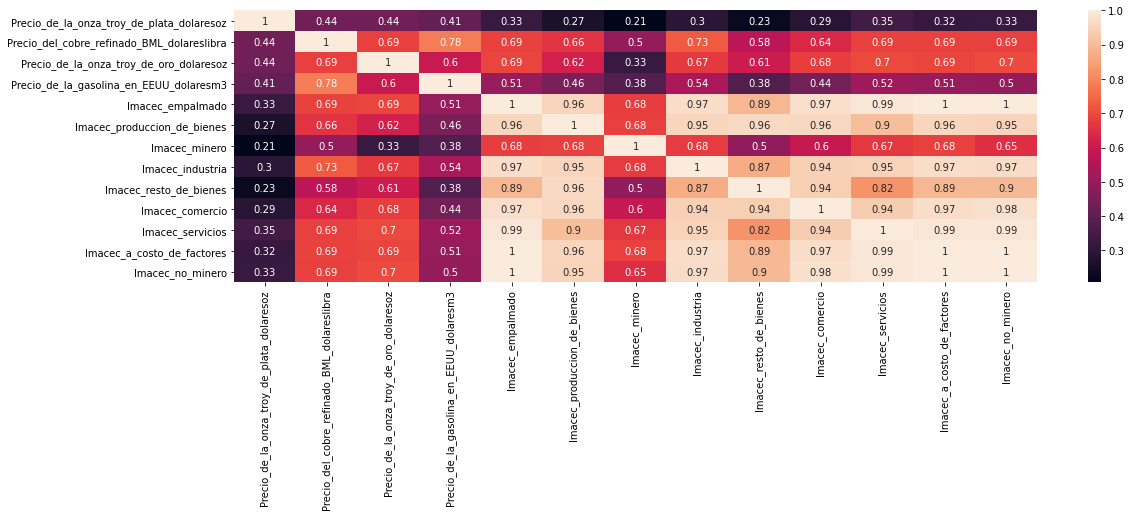

In [49]:
sns.heatmap(banco[banco_cols].corr(), annot=True);

Con respecto a las columnas del PIB, vemos que todas están correlacionadas con al menos alguna otra columna

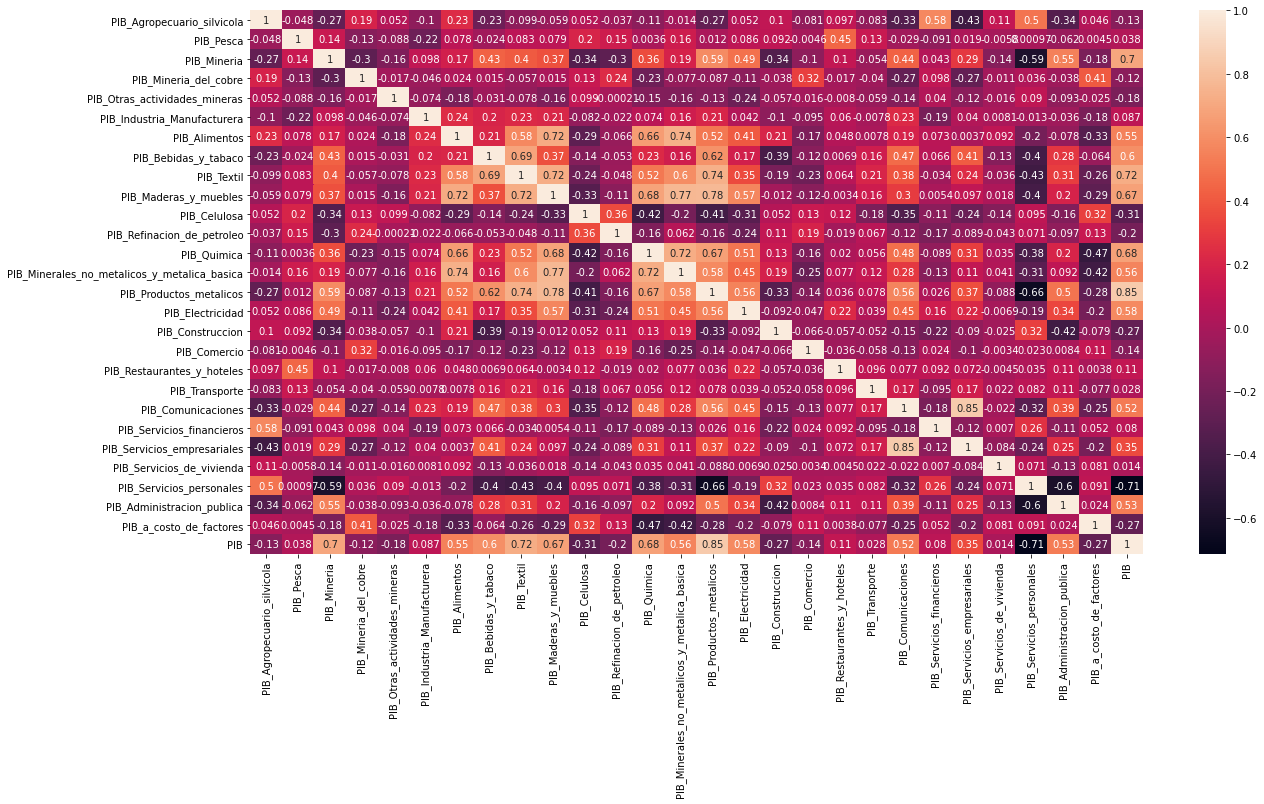

In [50]:
plt.figure(figsize = (20,10))
sns.heatmap(banco[pib_cols].diff().corr(), annot=True);

Podríamos escoger a mano qué columnas usar, pero podemos automatizar el proceso y volver a agregar columnas a mano que consideremos importantes si el modelo no es suficientemente bueno.

In [51]:
corr_matrix = banco.diff().corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

## 4.2 Datos Precio leche

In [52]:
precios = pd.read_csv("precio_leche.csv")
precios.head(2)

Anio  Mes  Precio_leche
0  1979  Ene          3.85
1  1979  Feb          4.58

In [53]:
precios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Anio          506 non-null    int64  
 1   Mes           506 non-null    object 
 2   Precio_leche  506 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 12.0+ KB


Notamos que no hay valores faltantes y los meses están ordenados por lo que podemos pasarlos a sus valores numéricos haciendo un mapping entre los meses y $\{1, ..., 12\}$

In [54]:
precios["Mes"] = precios["Mes"].map(dict(zip(precios.Mes.unique(), range(1,13))))

Creamos la columna **date** con el mismo formato de los otros datos insertandola en la posición 0

In [55]:
precios.insert(0, "date", pd.to_datetime(precios["Anio"].astype(str) + "-" + precios["Mes"].astype(str) + "-01" ) )
precios.head(2)

date  Anio  Mes  Precio_leche
0 1979-01-01  1979    1          3.85
1 1979-02-01  1979    2          4.58

### Merge

In [56]:
precipitaciones.drop(columns = ["Year", "Mes"], inplace = True)

In [57]:
precios = precios.merge(precipitaciones, on = "date", how = "left")
precios.tail()

date  Anio  Mes  Precio_leche  Coquimbo  Valparaiso  \
501 2020-10-01  2020   10        274.32       NaN         NaN   
502 2020-11-01  2020   11        288.09       NaN         NaN   
503 2020-12-01  2020   12        287.29       NaN         NaN   
504 2021-01-01  2021    1        287.60       NaN         NaN   
505 2021-02-01  2021    2        295.24       NaN         NaN   

     Metropolitana_de_Santiago  Libertador_Gral__Bernardo_O_Higgins  Maule  \
501                        NaN                                  NaN    NaN   
502                        NaN                                  NaN    NaN   
503                        NaN                                  NaN    NaN   
504                        NaN                                  NaN    NaN   
505                        NaN                                  NaN    NaN   

     Biobio  La_Araucania  Los_Rios  
501     NaN           NaN       NaN  
502     NaN           NaN       NaN  
503     NaN           NaN       NaN  
504     NaN           NaN       NaN  
505     NaN           NaN       NaN

In [58]:
banco_cols = ["Precio_de_la_onza_troy_de_plata_dolaresoz", "Precio_del_cobre_refinado_BML_dolareslibra", 
              "Precio_de_la_onza_troy_de_oro_dolaresoz", "Precio_de_la_gasolina_en_EEUU_dolaresm3"] + imacec_cols + pib_cols
precios = precios.merge(banco[banco_cols].reset_index(), left_on="date", right_on="Periodo", how = "left")

In [59]:
# to_drop son las features con correlación alta
precios.drop(columns = to_drop + ["Periodo"], inplace = True)

## 4.3 Creación de variables

### 4.3.1 A partir de Autocorrelación

<AxesSubplot:xlabel='date'>

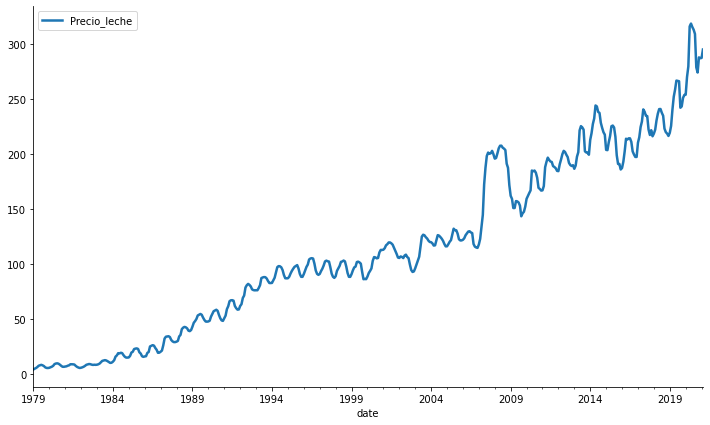

In [60]:
precios.plot(x = "date", y = "Precio_leche", figsize = (12, 7 ))

In [61]:
from statsmodels.tsa.stattools import adfuller

# ref https://towardsdatascience.com/time-series-from-scratch-stationarity-tests-and-automation-14b02fa5ca4d
def make_stationary(data: pd.Series, alpha: float = 0.05, max_diff_order: int = 10) -> dict:
    # Test to see if the time series is already stationary
    if adfuller(data)[1] < alpha:
        return {
            'differencing_order': 0,
            'time_series': np.array(data)
        }
    
    # A list to store P-Values
    p_values = []
    
    # Test for differencing orders from 1 to max_diff_order (included)
    for i in range(1, max_diff_order + 1):
        # Perform ADF test
        result = adfuller(data.diff(i).dropna())
        # Append P-value
        p_values.append((i, result[1]))
        
    # Keep only those where P-value is lower than significance level
    significant = [p for p in p_values if p[1] < alpha]
    # Sort by the differencing order
    significant = sorted(significant, key=lambda x: x[0])
    
    # Get the differencing order
    diff_order = significant[0][0]
    
    # Make the time series stationary
    stationary_series = data.diff(diff_order).dropna()
    
    return {
        'differencing_order': diff_order,
        'time_series': np.array(stationary_series)
    }

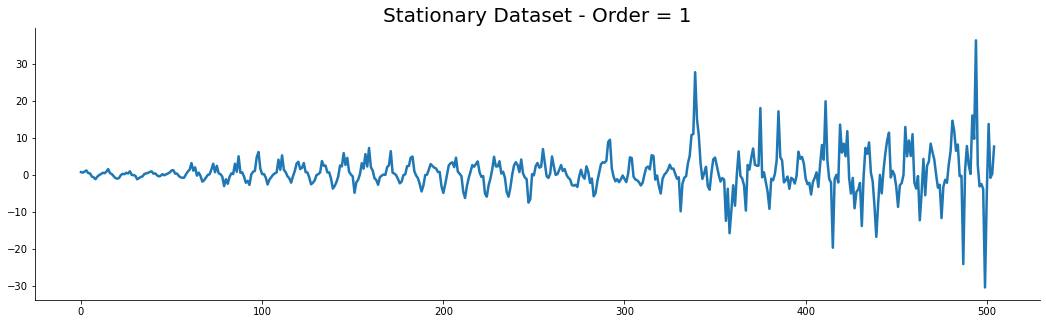

In [62]:
ap_stationary = make_stationary(
    data=precios['Precio_leche']
)

plt.title(f"Stationary Dataset - Order = {ap_stationary['differencing_order']}", size=20)
plt.plot(ap_stationary['time_series']);

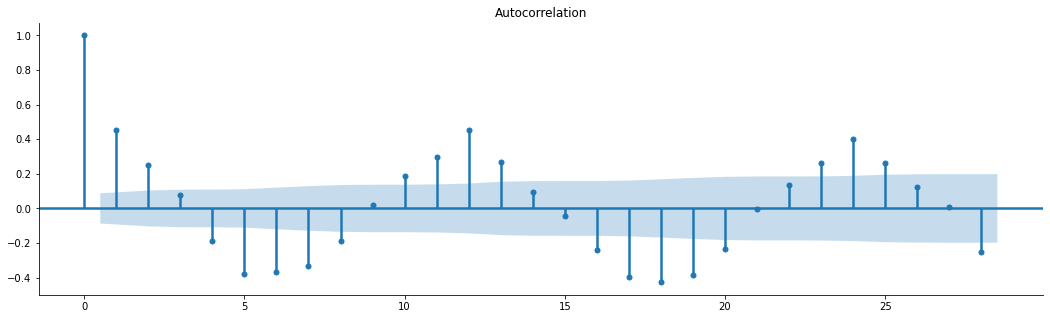

In [63]:
plot_acf(precios['Precio_leche'].diff().dropna());

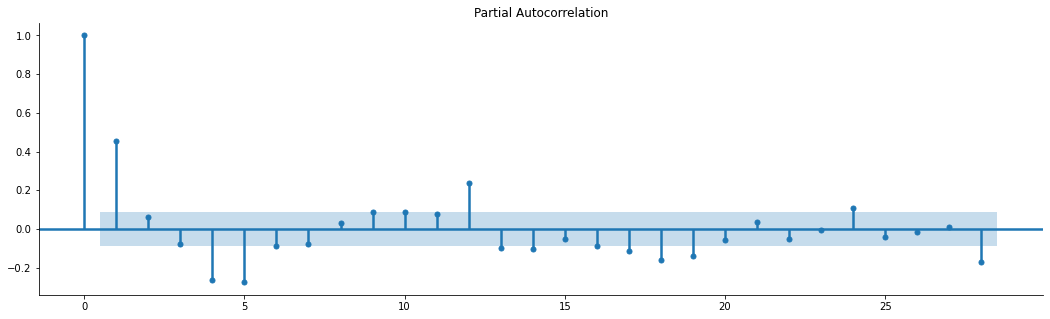

In [64]:
plot_pacf(precios['Precio_leche'].diff().dropna());

Con todos los datos del mes $t$ queremos predecir el precio del mes $t+1$, por esta razón, hacemos un shift en -1 a la columna "Precio_leche" y le cambiamos el nombre a "y".
Esta variable se transforma en nuestro target.

In [65]:
precios["y"] = precios["Precio_leche"].shift(-1)
precios.dropna(subset = ["y"], inplace = True)

In [66]:
shifts = [2, 4, 12, 14, 18, 24]
many_shifts = {f"Precio_leche_lag{i}": precios["Precio_leche"].shift(i-1) for i in shifts}
precios = precios.join(pd.DataFrame(many_shifts))
del shifts, many_shifts; gc.collect();

### A partir de la fecha

Dado que el Mes es una feature ordinal cíclica y que no utilizaremos un modelo basados en árboles de decisión, podemos transformar
la columna mes a una feature cíclica utilizando funciones trigonométricas, en este caso, como los valores máximos se encuentran a mitad
de año, la función $-cos(x)$ nos debería dar buena señal.

In [67]:
precios.groupby("Mes")["Precio_leche"].mean()

Mes
1     108.326512
2     106.578571
3     110.671905
4     114.582619
5     119.966667
6     121.310476
7     121.056429
8     120.046905
9     114.370238
10    111.489286
11    110.887381
12    109.893810
Name: Precio_leche, dtype: float64

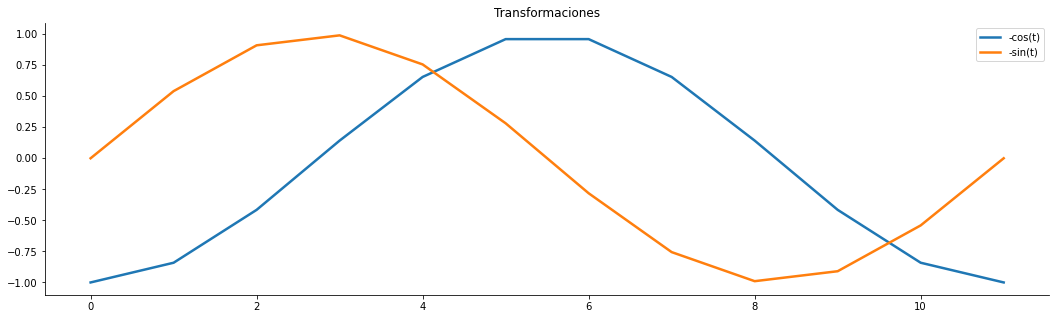

In [68]:
(-1*np.cos(2*np.pi*(precios.Mes - 1 ) / 11)).iloc[:12].plot(legend = True, label = "-cos(t)");
( np.sin(2*np.pi*(precios.Mes - 1 ) / 11)).iloc[:12].plot(title = "Transformaciones", legend = True, label = "-sin(t)");

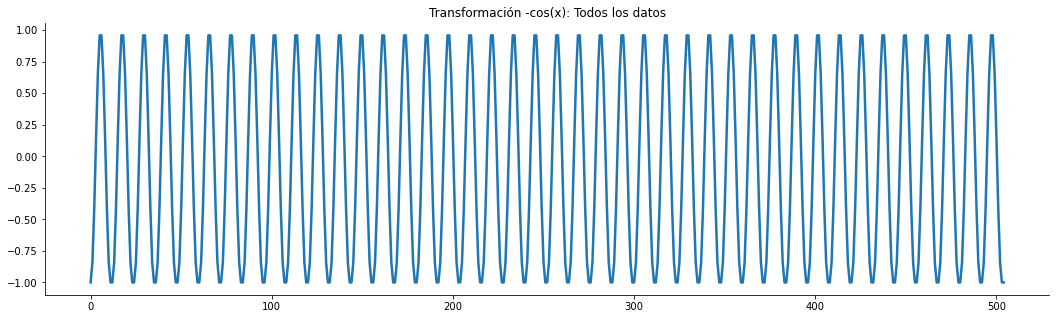

In [69]:
(-1*np.cos(2*np.pi*(precios.Mes - 1 ) / 11)).plot(title = "Transformación -cos(x): Todos los datos");

In [70]:
precios["cos_Mes"] = -1*np.cos(2*np.pi*(precios.Mes - 1 ) / 11)
precios["sin_Mes"] =  np.sin(2*np.pi*(precios.Mes - 1 ) / 11)

Vemos que las 2 features que introdujimos cumplen con estar a distancia constante y ser cíclicas

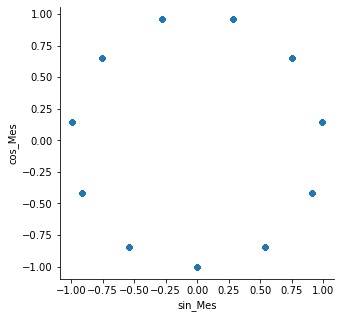

In [71]:
precios.sample(500).plot.scatter('sin_Mes','cos_Mes').set_aspect('equal');

**Trimestre**

In [72]:
precios["trimestre"] = np.ceil(precios["Mes"] / 3)

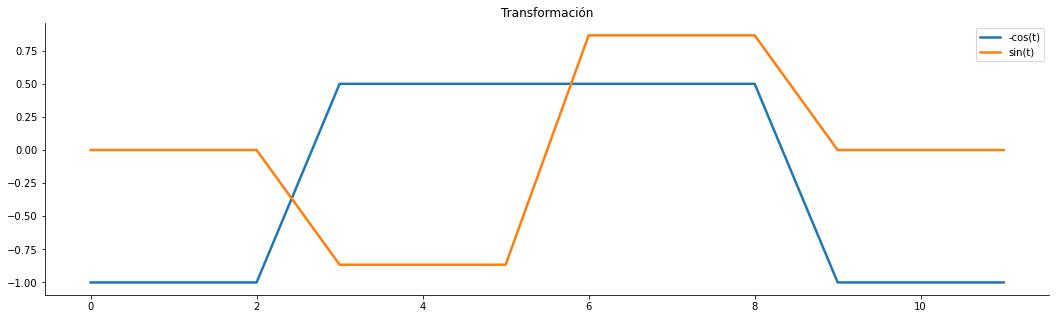

In [73]:
(-np.cos(2*np.pi*(precios.trimestre - 1 ) / 3)).iloc[:12].plot(legend = "-cos(t)", label = "-cos(t)");
(-np.sin(2*np.pi*(precios.trimestre - 1 ) / 3)).iloc[:12].plot(title = "Transformación", label = "sin(t)", legend = True);

Esta transformación hace que perdamos un punto, dado que $cos(\frac{2\pi}{3}) = cos(\frac{4\pi}{3}) = 1/2$.

In [74]:
precios["cos_trimestre"] =-np.cos(2*np.pi*(precios.trimestre - 1 ) / 3)
precios["sin_trimestre"] = -np.sin(2*np.pi*(precios.trimestre - 1 ) / 3)

In [75]:
precios.drop(columns = ["Mes", "trimestre"], inplace = True)

### Variables relacionadas al clima

In [76]:
prep_regions = ["Coquimbo", 'Valparaiso', 'Metropolitana_de_Santiago', 'Libertador_Gral__Bernardo_O_Higgins', 'Maule', 'Biobio',
               'La_Araucania', 'Los_Rios']
prep_regions_diff = ["diff_"+reg for reg in prep_regions]
precios[prep_regions_diff] = precios[prep_regions].diff()
precios.head()

date  Anio  Precio_leche   Coquimbo  Valparaiso  \
0 1979-01-01  1979          3.85   2.641948    0.587062   
1 1979-02-01  1979          4.58   1.179804    2.432192   
2 1979-03-01  1979          5.18   0.255490    0.020601   
3 1979-04-01  1979          6.06  10.173699   11.745779   
4 1979-05-01  1979          7.25   1.039098   18.609286   

   Metropolitana_de_Santiago  Libertador_Gral__Bernardo_O_Higgins       Maule  \
0                   2.447114                             1.608992    3.736215   
1                   3.997852                             4.346310   16.347637   
2                   0.000000                             0.055488    0.545324   
3                  13.722349                            12.989194   21.880607   
4                  50.187148                           104.451550  143.914334   

       Biobio  La_Araucania  ...  cos_trimestre  sin_trimestre  diff_Coquimbo  \
0   17.859634     25.212940  ...           -1.0      -0.000000            NaN   
1   17.680612     18.085072  ...           -1.0      -0.000000      -1.462144   
2   14.435698     28.696504  ...           -1.0      -0.000000      -0.924314   
3   39.136483     43.617921  ...            0.5      -0.866025       9.918209   
4  219.729235    279.409718  ...            0.5      -0.866025      -9.134601   

   diff_Valparaiso  diff_Metropolitana_de_Santiago  \
0              NaN                             NaN   
1         1.845130                        1.550738   
2        -2.411591                       -3.997852   
3        11.725179                       13.722349   
4         6.863506                       36.464799   

   diff_Libertador_Gral__Bernardo_O_Higgins  diff_Maule  diff_Biobio  \
0                                       NaN         NaN          NaN   
1                                  2.737318   12.611423    -0.179023   
2                                 -4.290822  -15.802313    -3.244914   
3                                 12.933705   21.335283    24.700785   
4                                 91.462356  122.033727   180.592753   

   diff_La_Araucania  diff_Los_Rios  
0                NaN            NaN  
1          -7.127867     -11.521408  
2          10.611432      32.157209  
3          14.921417       7.315879  
4         235.791797     364.456989  

[5 rows x 67 columns]

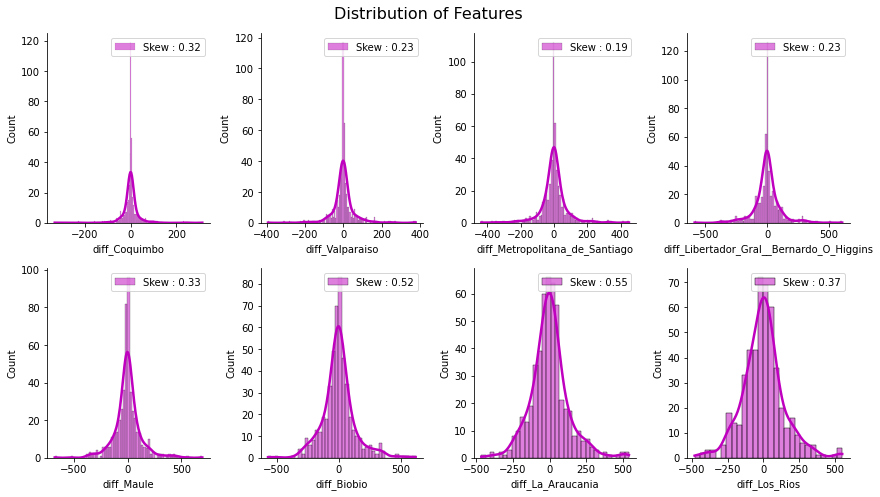

In [77]:
distplot(precios, prep_regions_diff, 2, 4, figsize = (12,7))

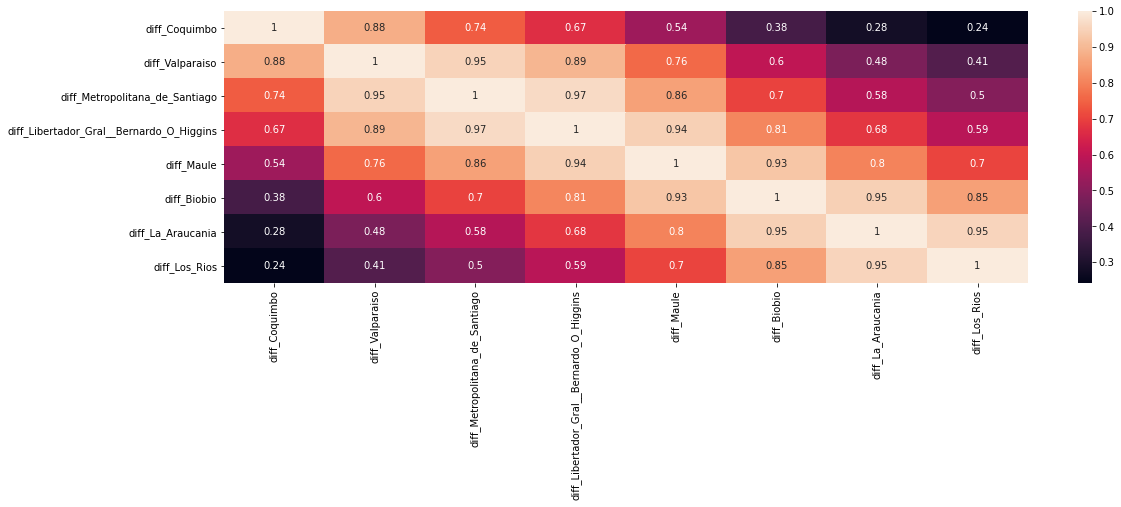

In [78]:
sns.heatmap(precios[prep_regions_diff].corr(), annot=True);

Regiones cercanas tienen alta correlación, por lo que eliminamos algunas.

In [79]:
precios.drop(columns = prep_regions + ['diff_Valparaiso'], inplace = True)

### Variables relacionadas al banco

In [80]:
banco_cols = [col for col in banco_cols if col not in to_drop]
precios_banco_features = precios.copy()

In [81]:
precios_banco_features[["Mean4_"+col for col in banco_cols]] = precios[banco_cols].rolling(4).mean()
precios_banco_features[["Std4_"+col for col in banco_cols]] = precios[banco_cols].rolling(4).std()

Consideramos los datos desde el 2013 para ver las correlaciones

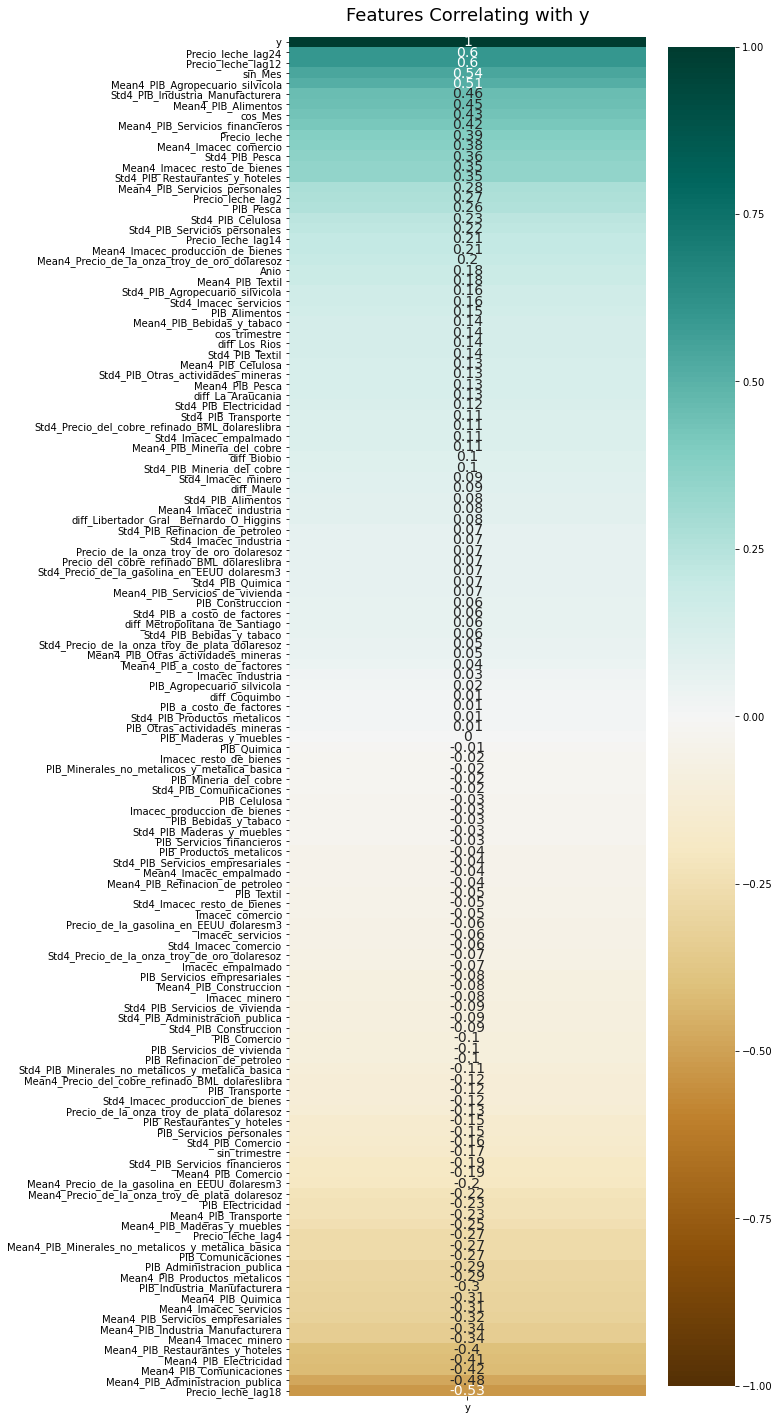

In [82]:
plot_corr_one_vs_all(precios_banco_features.set_index("date").loc["2013-01-01":].diff().dropna(), "y", figsize = (8, 25))

In [83]:
corr_matrix = precios_banco_features.set_index("date").loc["2013-01-01":].diff().dropna().corr().abs()
to_drop = corr_matrix[corr_matrix["y"] < 0.3].index.to_list()

In [84]:
print(f"Tenemos {precios_banco_features.shape[1]} columnas y eliminaremos {len(to_drop)} columnas con correlación menor a 0.3")

Tenemos 132 columnas y eliminaremos 107 columnas con correlación menor a 0.3


In [85]:
precios_banco_features = precios_banco_features.drop(columns = to_drop)

In [86]:
precios["Mean4_Imacec_industria"] = precios["Imacec_industria"].rolling(4).mean()
precios.drop(columns = banco_cols, inplace = True)

### Missing values

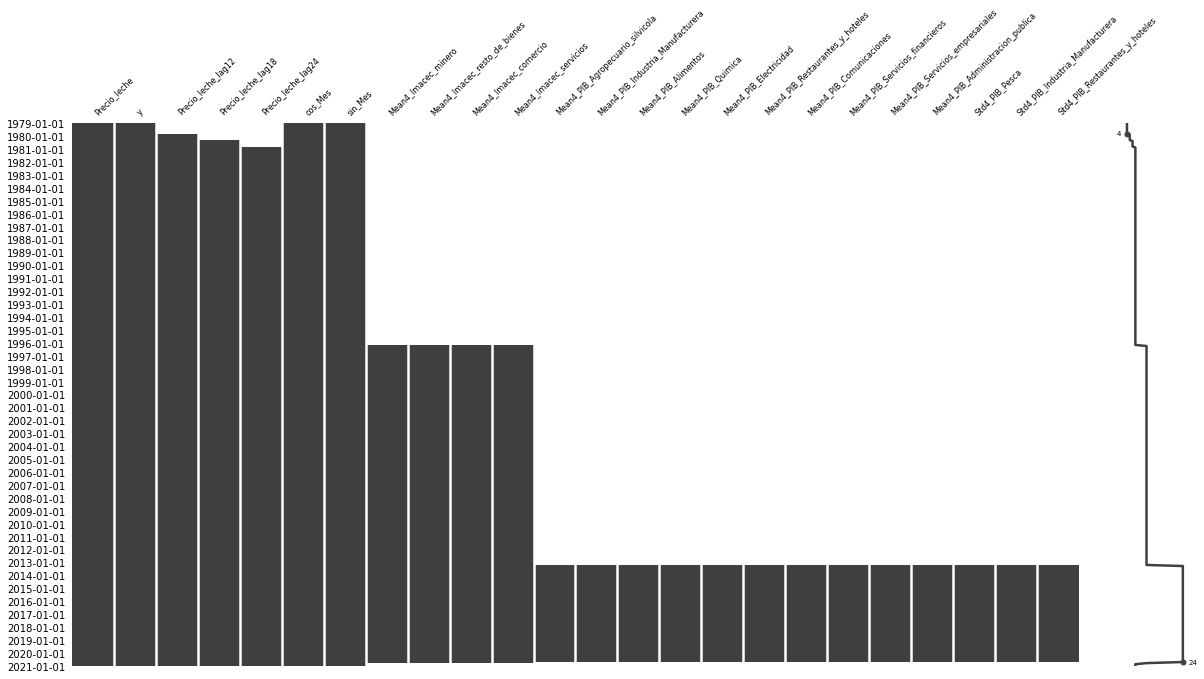

In [87]:
msno.matrix(precios_banco_features.set_index("date"), freq='YS', figsize = (20, 10), fontsize=8);

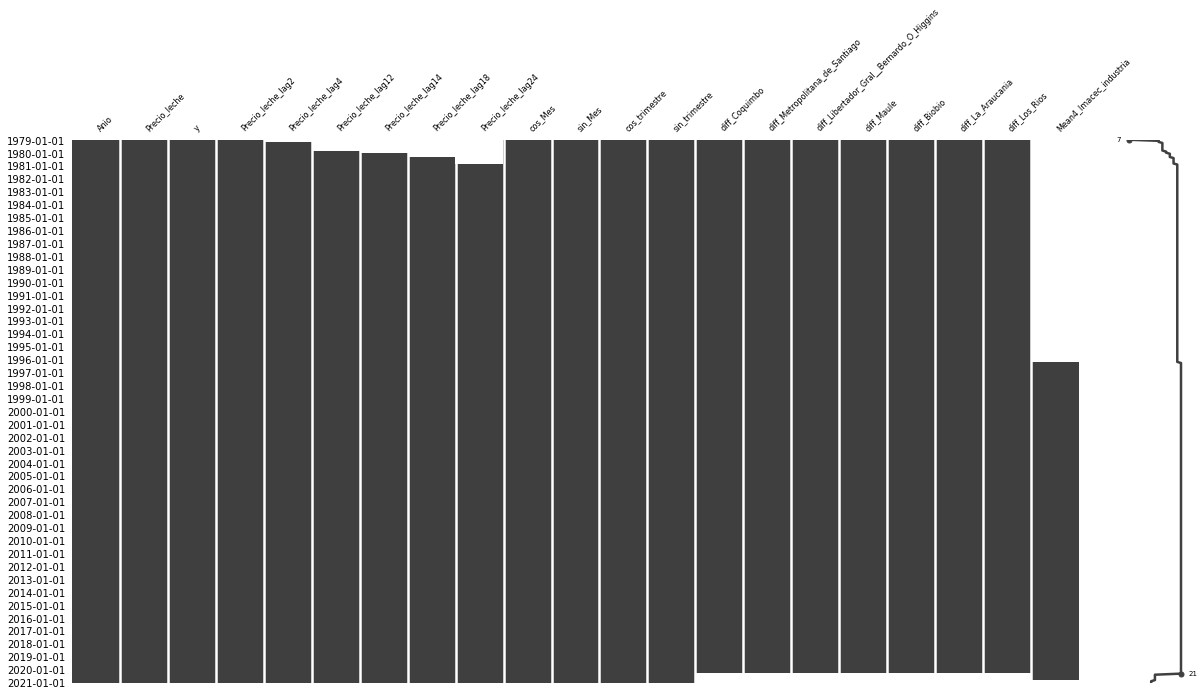

In [88]:
msno.matrix(precios.set_index("date"), freq='YS', figsize = (20, 10), fontsize=8);

# Modelo

Los precios de la leche tienen una tendencia al alza, dado que los modelos basados en árboles de decisión no son buenos extrapolando, tendremos que utilizar otro tipo de modelos, ya sean lineales, basados en medias moviles autoregresivos u otros.  

En este caso, elegí utilizar Prophet que en general tiene buen rendimiento en este tipo de problemas.

En cuanto al set de entrenamiento, tomé uno sin las variables del PIB, la limpieza que hice no fue suficientemente buena por lo que el trade-off de perder datos de los años 1979 a 2013 a cambio de agregar tales columnas impactaba negativamente al modelo.

## 5.1 Entrenamiento Modelo: Prophet

In [89]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

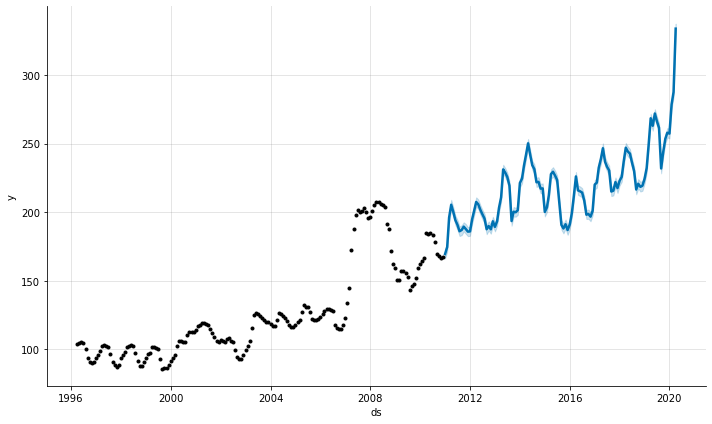

CPU times: user 2.2 s, sys: 169 ms, total: 2.37 s
Wall time: 2.23 s


In [90]:
%%time

cols = precios.columns[1:].to_list()
cols.remove('y')

m = Prophet(seasonality_mode='additive', weekly_seasonality = False, daily_seasonality = False)

X = precios.copy()
X.rename(columns = {"date":"ds"}, inplace = True)

X.dropna(subset = cols + ["y"], inplace = True)

X_train = X[X["ds"] < "2011-01-01"]
X_test = X[X["ds"] >= "2011-01-01"]


# m.add_regressor("Precio_leche")
for col in cols:
    m.add_regressor(col)
    
m.fit(X_train)
forecast = m.predict(X_test)

m.plot(forecast)
plt.show()

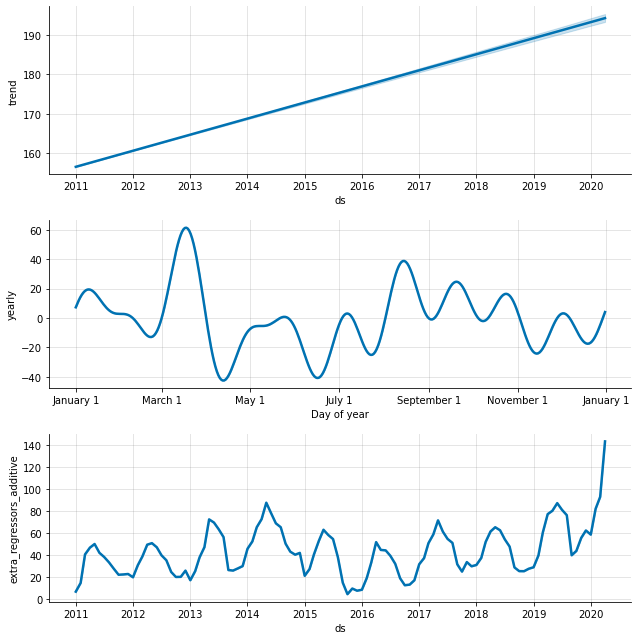

In [91]:
fig = m.plot_components(forecast)

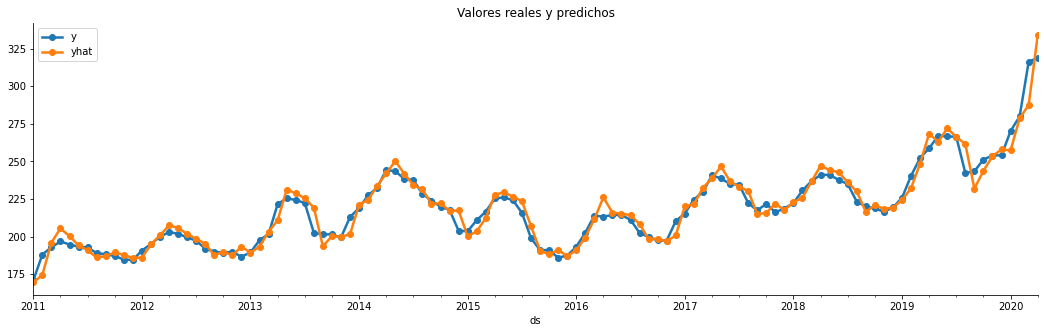

In [92]:
X_test.reset_index(drop = True).join(forecast["yhat"]).set_index("ds")[["y", "yhat"]].plot(title = "Valores reales y predichos", style = "o-");

In [93]:
mae = mean_absolute_error(X_test["y"], forecast["yhat"])
rmse = mean_squared_error(X_test["y"], forecast["yhat"], squared=False)
mape = mean_absolute_percentage_error(X_test["y"], forecast["yhat"])
print(f"MAE: {mae.round(2)}, RMSE: {rmse.round(3)}, MAPE: {mape.round(3)}")

MAE: 4.46, RMSE: 6.306, MAPE: 0.02


Revisemos los residuos

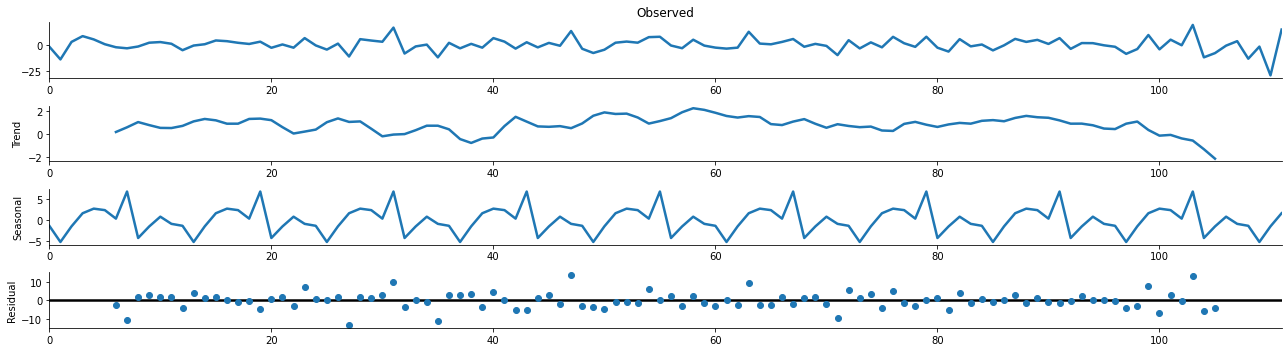

In [94]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(forecast["yhat"].values - X_test["y"].values, period=12).plot();

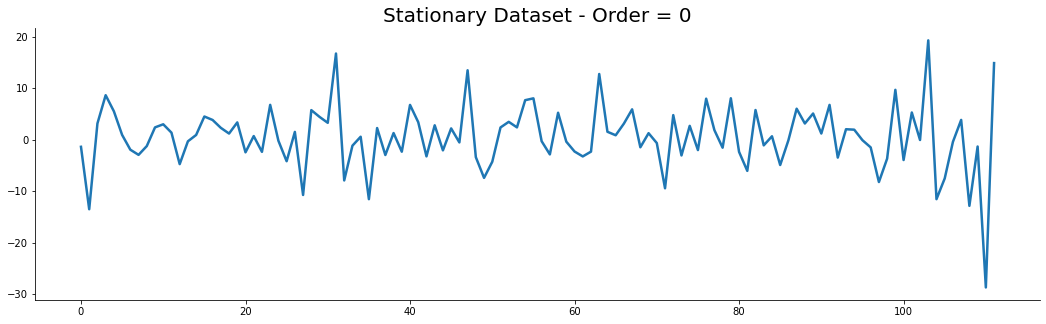

In [95]:
ap_stationary = make_stationary(
    data= pd.DataFrame(forecast["yhat"].values - X_test["y"].values)
)

plt.title(f"Stationary Dataset - Order = {ap_stationary['differencing_order']}", size=20)
plt.plot(ap_stationary['time_series']);

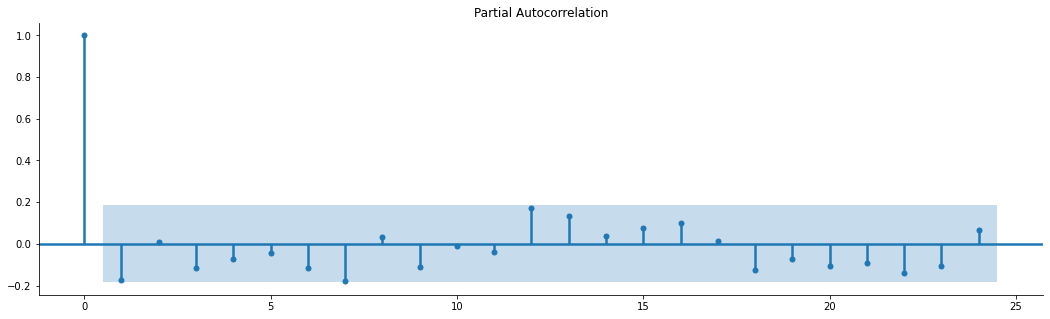

In [96]:
plot_pacf(ap_stationary["time_series"], lags = 24);

In [97]:
results = X_test.reset_index(drop = True).join(forecast["yhat"]).set_index("ds")[["Anio", "y", "yhat", "Precio_leche"]]

In [98]:
def compare(df):
    return mean_absolute_error(df["y"], df["Precio_leche"]) - mean_absolute_error(df["y"], df["yhat"])

## 5.2 Baseline

Pondremos como modelo baseline uno que entrega como precio para el siguiente mes, el precio del mes actual.

In [99]:
baseline_mae = mean_absolute_error(X_test["Precio_leche"], X_test["y"])
print(f"Mejoramos el modelo baseline en: {(baseline_mae - mae).round(2)} pesos durante los 9 años en test")

Mejoramos el modelo baseline en: 1.04 pesos durante los 9 años en test


Veamos los resultados del modelo vs modelo baseline por año

In [100]:
results.groupby("Anio").apply(compare)

Anio
2011   -0.330003
2012    0.222624
2013    0.868685
2014    2.358878
2015    1.354497
2016    1.119927
2017    1.552167
2018    1.192136
2019    0.764231
2020    1.752387
dtype: float64

## 5.3 Preguntas y respuestas

- Construye una base de test (o de cross validation). ¿Cuál fue tu definición de tiempo/cantidad de datos para este set de datos? Explica por qué la elegiste así.

**Respuesta**:

Al ser una serie de tiempo tenemos que hacer una separación temporal. ```Prophet``` trae un método de validación cruzada implementado, pero por simplicidad en la comparación con el modelo baseline, preferí separar los datos en ~ 15 años de entrenamiento (177 meses) y ~ 9 (112 meses) de test, esto es, $\approx  \frac{2}{3}$ de datos en entrenamiento y $\approx  \frac{1}{3}$ en test, lo tomé más grande del 80/20 típico, para ver qué tan robusto era dado que iba a utilizar solo un set de entrenamiento y no validación cruzada.

Por otro lado, se parte del año 1996 con los datos de entrenamiento, porque tenemos features que vienen del Imacec.

Si utilizamos datos del PIB, tendríamos que comenzar en el año 2013, acortando bastante la cantidad de datos. Con más tiempo, podríamos limpiar bien estos datos o hacer un mejor análisis para generar features que nos den más señal, mejorando el modelo.

- ¿Qué datos adicionales te gustaría tener?¿Qué datos son necesarios para que este modelo funcione/mejore las métricas?

**Respuesta**:

Me gustaría tener los siguientes datos adicionales:

- Inflación, con esto podemos hacer una columna que indique en cuánto ha variado el precio con respecto a un precio base.
- Precios mensuales de productos relacionados a la leche, como el queso o yogurt.
- Datos relacionados a la sequía nos proporcionaron poder predictivo, en efecto, el modelo sin los datos de precipitaciones obtenía peores predicciones. Por lo que tener más datos relacionados a las condiciones meteorológicas sería un aporte.
- Datos del PIB anteriores al 2013.

Creo que los mismos datos mencionados anteriormente servirían para mejorar las métricas.

- ¿Cómo evalúas el resultado del modelo?¿Qué métricas tiene sentido mirar?

**Respuesta**: 

Tiene sentido mirar al error absoluto promedio, pues estamos hablando de precios, por lo que equivocarnos en 10 pesos es 10 veces peor que equivocarnos en 1 peso, en términos de dinero. Por otro lado, este valor por si sólo no nos dice qué tan bueno fue el modelo sin saber su tamaño comparado con los valores del precio de la leche, por lo que también tiene sentido mirar a MAPE. En caso de que para el cliente o aplicación que estamos realizando perder 10 pesos no sea 10 veces peor que perder 1 peso, sino que más, entonces podemos mirar RMSE.

Es bueno tener un modelo dummy base que represente cómo se están prediciendo los precios, sin utilizar algoritmos y modelos. En este caso, podemos pensar en un modelo que da como predicción para el mes siguiente el mismo precio del mes actual. El modelo entregado le gana a este modelo dummy consistentemente desde el año 2012 en las métricas mencionadas anteriormente.

Finalmente, tiene sentido también mirar a los residuos una vez que los transformamos en estacionarios. Si la transformación tiene las características de ruido blanco, entonces el modelo está haciendo predicciones suficientemente buenas con los datos entregados, si no, aún hay espacio para mejorar. En el caso del modelo actual, aún hay un pequeño espacio de mejora, podemos intentar mejorar solo con hiperparámetros utilizando ```optuna``` o similares. 

- ¿Para qué aplicaciones puede servir un modelo de este tipo? En particular, ¿Cómo podría ayudar a combatir el cambio climático?

**Respuesta**

El modelo que acabamos de crear nos da una estimación del precio de la leche, lo que está relacionado con la demanda por tales productos. Esto puede ayudar a empresas o personas naturales que quieren planificar sus pedidos de leche.

Los modelos se series de tiempo tienen un gran impacto en el día a día, un problema que conozco es en energías renovables y cómo implementarlas en los mercados, en particular, hay un tipo de mercado en donde cada generador de energía (convencional o renovable) entrega sus pujas (bids) a un organismo central e independiente, el cual asigna las cantidades a producir y precio tales que minimicen el costo total de la red. Los generadores de energía eligen las pujas de manera de ganar la mayor cantidad de dinero posible (si dan un precio muy alto, el organismo central les asignará 0 producción) resolviendo un problema de optimización. Una de las dificultades que tienen los productores de energías renovables en estos mercados es que su capacidad de producción no es determinista, un modelo de este tipo puede ayudar elegir un valor y transformar el problema en determinista, o acotar el espacio en donde vive la capacidad, para que luego el problema de optimización pueda ser resuelto más fácilmente. En este sentido, estaríamos ayudando a introducir generadores de energía renovables al mercado y por lo tanto combatiendo el cambio climático.

Podemos crear modelos que tengan que ver directamente con el cambio climático, por ejemplo viendo como han disminuído las precipitaciones durante los últimos años. La gracia es al agregarle variables al modelo, podemos ver su impacto en la disminución de precipitaciones, luego generar un análisis estadístico cuidadoso para detectar la importancia de estas variables positiva o negativa, por ejemplo variables asociadas a emisiones de gases de efecto invernadero deberían tener un impacto negativo, y por lo tanto, uno puede entregar recomendaciones con respecto a cómo mejorar y dar predicciones sobre cómo empeorarán las condiciones en caso de no tomar acciones.

**¡Muchas gracias por tu tiempo y por la oportunidad. Que tengas un buen día!**